<a href="https://colab.research.google.com/github/lopezd16/Equipo4_proyecto_integrador/blob/main/Avance4_4Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Comparar distintos modelos es una práctica esencial porque permite tomar una decisión informada, optimizando el balance entre rendimiento, costo, interpretabilidad y adecuación al problema. La comparación de distintos modelos ayuda a identificar posibles oportunidades de cada opción y permite la elección de la mejor opción dependiendo el objetivo de la solución.

## Contexto
El presente proyecto tiene como objetivo aplicar técnicas de Inteligencia Artificial y Aprendizaje Automático (AI/ML) para identificar y alertar a los usuarios de lo que esta pasando en el mundo de las criptomonedas de forma oportuna y digerida. La investigación se enfocará en el mercado al momento dado que las herramientas actuales carecen del la capacided de dar información en tiempo real.

# ¿Qué estamos haciendo?

- **Ingesta**: bajamos noticias cripto (NewsAPI) y datos de mercado/categorías (CoinGecko).

- **Limpieza + Enlace:** limpiamos texto, detectamos tokens (BTC, ETH…) y los mapeamos a categorías (Bitcoin, Stablecoins, L1…). Así cada nota queda ligada a un segmento del mercado.

- **Temas (LDA):** a cada noticia le calculamos probabilidades de tema (p. ej., Regulación/ETF, Stablecoins/Pagos, Hacks…), no solo el índice.

- **Dataset integrado:** unimos noticia+tema+categoría con métricas de mercado (market cap, volumen, cambios) y creamos features (PCs, residuo volumen~MC).

- **Clasifiación de categorías y temas de noticas :** Se generan etiquetas comparando openai y TF‑IDF

- **Crear una señal de tema emergente :** Comparando días anteriores, comparamos posibles temas recurrentes y crecientes.

- **Evaluar usando regresión logística :** Evaluamos la señal generada en el periodo anterior vs lo que realmente sucedió.

-------------Phase 1 "Setup Data" ---------------------------

In [ ]:
!pip install unidecode

In [ ]:
import os
import re
import time
import json
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime, timezone, timedelta

In [ ]:
CDMX_TZ = timezone(timedelta(hours=-6))
now_cdmx = datetime.now(CDMX_TZ)
BASE_TODAY = (now_cdmx - timedelta(days=1)).date()

NEWSAPI_KEY   = os.getenv("NEWSAPI_KEY", "NO SUBIR")
NEWS_QUERY    = "crypto"   #El tema en cuestión
NEWS_LANG     = "en"       # "en" o "es" depende del idioma
NEWS_PAGESIZE = 100
NEWS_SORT     = "popularity"   # relevancy|popularity|publishedAt
BASE_TODAY = (now_cdmx - timedelta(days=1)).date()
NEWS_FROM = (BASE_TODAY - timedelta(days=1)).strftime("%Y-%m-%d")
NEWS_TO   = BASE_TODAY.strftime("%Y-%m-%d")

COINGECKO_MARKETS_URL    = "https://api.coingecko.com/api/v3/coins/markets"
COINGECKO_CATEGORIES_URL = "https://api.coingecko.com/api/v3/coins/categories"
VS_CURRENCY       = "usd"
MARKETS_PER_PAGE  = 100
MARKETS_PAGES     = 1

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#---------------------------------------------------------------------------

URL_PATTERN      = re.compile(r"http\S+|www\.\S+")
HTML_TAG_PATTERN = re.compile(r"<.*?>")

def clean_text(txt: str) -> str:
    """
    Limpieza de texto para noticias:
      - Quita HTML y URLs.
      - Conserva caracteres alfanuméricos básicos, acentos y puntuación simple.
      - Normaliza espacios.
    """
    if not isinstance(txt, str):
        return ""
    txt = re.sub(HTML_TAG_PATTERN, " ", txt)
    txt = re.sub(URL_PATTERN, " ", txt)
    txt = re.sub(r"[^A-Za-z0-9ÁÉÍÓÚáéíóúñÑ .,!?()\-:;%/]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def normalize_symbol(sym: str, max_len: int = 5) -> str:
    """
    Normaliza el símbolo de la cripto:
      - Solo letras (sin números/guiones).
      - Mayúsculas.
      - Longitud máxima = 5 (ej. BTC, ETH, SOL).
    """
    if not isinstance(sym, str):
        return ""
    sym = re.sub(r"[^A-Za-z]", "", sym).upper()
    return sym[:max_len]

def split_datetime_iso8601(ts: str):
    """
    Convierte una marca de tiempo ISO8601 a:
      (fecha_dd/mm/yyyy, hora_HH:MM:SS).
    Soporta sufijo 'Z' y offsets.
    """
    if not isinstance(ts, str) or not ts:
        return "", ""
    try:
        dt = datetime.fromisoformat(ts.replace("Z", "+00:00"))
        return dt.strftime("%d/%m/%Y"), dt.strftime("%H:%M:%S")
    except Exception:
        return "", ""

#---------------------------------------------------------------------

def fetch_newsapi(query=NEWS_QUERY, language=NEWS_LANG, pagesize=NEWS_PAGESIZE,
                  sortby=NEWS_SORT, api_key=NEWSAPI_KEY, from_date=NEWS_FROM, to_date=NEWS_TO, page=1):
    """
    Descarga noticias desde NewsAPI. Si no hay API key, devuelve un lote DEMO.
    """
    if not api_key:
        return {
            "status": "ok",
            "totalResults": 3,
            "articles": [
                {
                    "source": {"id": "business-insider", "name": "Business Insider"},
                    "author": "Henry Chandonnet",
                    "title": "Marc Benioff on AGI 'hypnosis' – what it means for crypto markets",
                    "description": "Salesforce CEO doubts AGI hype. <b>Markets react</b>. Read more at https://example.com ...",
                    "url": "https://www.businessinsider.com/marc-benioff-extremely-suspect-agi-hypnosis-2025-8",
                    "urlToImage": "https://i.insider.com/img.jpg",
                    "publishedAt": "2025-08-28T18:12:29Z",
                    "content": "AGI hype & crypto: visit https://foo.bar for details. <ul><li>BTC up?</li></ul>"
                },
                {
                    "source": {"id": None, "name": "Reuters"},
                    "author": None,
                    "title": "ETF Bitcoin receives approval; volatility ahead?",
                    "description": "Regulators approve ETF. Markets brace for swings.",
                    "url": "https://www.reuters.com/markets/bitcoin-etf-approved-2025-08-28/",
                    "urlToImage": None,
                    "publishedAt": "2025-08-28T09:00:02Z",
                    "content": "Analysts expect higher inflows. Read at http://reuters.com/article?id=xyz."
                },
                {
                    "source": {"id": "ft", "name": "Financial Times"},
                    "author": "FT Staff",
                    "title": "DeFi growth accelerates in Latin America 🚀",
                    "description": "TVL climbs 15% this week; key protocols show strength.",
                    "url": "https://www.ft.com/content/defi-growth-latam",
                    "urlToImage": "https://www.ft.com/img.jpg",
                    "publishedAt": "2025-08-29T01:20:00Z",
                    "content": "DeFi momentum across ETH, SOL. <a href='https://ft.com/defi'>link</a>"
                },
            ]
        }
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": language,
        "pageSize": pagesize,
        "sortBy": sortby,
        "apiKey": api_key,
        "page": page
    }
    if from_date: params["from"] = from_date
    if to_date:   params["to"]   = to_date
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_markets(vs_currency=VS_CURRENCY, per_page=MARKETS_PER_PAGE, page=1):
    """
    Descarga el ranking de criptomonedas por market cap (hasta 'per_page' por página).
    """
    params = {
        "vs_currency": vs_currency,
        "order": "market_cap_desc",
        "per_page": per_page,
        "page": page,
        "sparkline": "false"
    }
    r = requests.get(COINGECKO_MARKETS_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_categories():
    """
    Descarga categorías (Layer1, DeFi, PoW, etc.) con market cap y top 3 coins por categoría.
    """
    r = requests.get(COINGECKO_CATEGORIES_URL, timeout=30)
    r.raise_for_status()
    return r.json()

# Ejecutar las 3 descargas********************************************************************************************************
# ================================
# 🔁 Descarga noticias de 3 días consecutivos (prioridad: más recientes)
# ================================
CDMX_OFFSET = "-06:00"  # cambia a "-05:00" si aplica
today_cdmx = now_cdmx.date()                    # ya definido arriba
yesterday_cdmx = (now_cdmx - timedelta(days=1)).date()

# --- Utilidades de time-slicing ---
def build_time_windows_for_quota(quota: int):
    """
    Devuelve ventanas [(h_ini, h_fin), ...] que cubren 24h y cuya cantidad sea ceil(quota/100).
    Si quota<=100 -> 1 ventana (00:00–23:59). Si quota=500 -> 5 ventanas equilibradas.
    """
    NEWS_PAGESIZE = 100
    n = max(1, int(np.ceil(quota / NEWS_PAGESIZE)))
    base = 24 // n
    rem  = 24 % n
    sizes = [base + (1 if i < rem else 0) for i in range(n)]
    windows, start = [], 0
    for sz in sizes:
        end = min(start + sz - 1, 23)
        windows.append((start, end))
        start = end + 1
    if windows:
        windows[-1] = (windows[-1][0], 23)
    return windows

def fetch_time_sliced(target_date_str: str, quota: int, tz_offset: str, query: str, lang: str, api_key: str):
    """
    Trae hasta 'quota' artículos de 'target_date_str' (día local) usando time-slicing con publishedAt.
    1 llamada por ventana; dedupe por URL.
    """
    windows = build_time_windows_for_quota(quota)
    seen_urls, collected = set(), []
    for idx, (h_ini, h_fin) in enumerate(windows, start=1):
        from_iso = f"{target_date_str}T{h_ini:02d}:00:00{tz_offset}"
        to_iso   = f"{target_date_str}T{h_fin:02d}:59:59{tz_offset}"
        try:
            data = fetch_newsapi(
                query=query, language=lang,
                pagesize=100, sortby="publishedAt",
                api_key=api_key, from_date=from_iso, to_date=to_iso, page=1
            )
            arts = data.get("articles", []) or []
            new_batch = [a for a in arts if a.get("url") and a["url"] not in seen_urls]
            for a in new_batch:
                seen_urls.add(a["url"])
            collected.extend(new_batch)
            print(f"   ▸ ventana {idx}/{len(windows)} [{h_ini:02d}:00–{h_fin:02d}:59] → {len(new_batch)} nuevas (total {len(collected)})")
            time.sleep(1)
            if len(collected) >= quota:
                break
        except Exception as e:
            print(f"   ⚠️ ventana {idx} error: {e}")
    df_day = pd.DataFrame(collected)
    df_day["fecha"] = target_date_str
    return df_day

# --- Recolección ---
news_frames = []

# A) HOY (día en curso, top del momento ≤100)
print(f"🟢 Hoy (CDMX): {today_cdmx} — top actual (≤100, popularity)")
try:
    data_today = fetch_newsapi(
        query=NEWS_QUERY, language=NEWS_LANG,
        pagesize=100, sortby="popularity",
        api_key=NEWSAPI_KEY,
        from_date=f"{today_cdmx}T00:00:00{CDMX_OFFSET}",
        to_date=f"{today_cdmx}T23:59:59{CDMX_OFFSET}",
        page=1
    )
    arts_today = data_today.get("articles", []) or []
    df_today = pd.DataFrame(arts_today)
    if not df_today.empty and "url" in df_today.columns:
        df_today = df_today.drop_duplicates(subset="url")
    df_today["fecha"] = today_cdmx.strftime("%Y-%m-%d")
    print(f"   ✅ Hoy: {len(df_today)} únicas")
except Exception as e:
    print(f"   ⚠️ Hoy error: {e}")
    df_today = pd.DataFrame(columns=["fecha"])
news_frames.append(df_today)

# B) AYER (día cerrado, objetivo 500 con time-slicing)
print(f"\n🟡 Ayer (CDMX): {yesterday_cdmx} — objetivo 500 (publishedAt + time-slicing)")
df_yesterday = fetch_time_sliced(
    target_date_str=yesterday_cdmx.strftime("%Y-%m-%d"),
    quota=500, tz_offset=CDMX_OFFSET, query=NEWS_QUERY, lang=NEWS_LANG, api_key=NEWSAPI_KEY
)
print(f"   ✅ Ayer: {len(df_yesterday)} únicas (objetivo 500)")
news_frames.append(df_yesterday)

# C) 5 días previos (–2..–6): cupos decrecientes con time-slicing
older_day_quota = {2: 80, 3: 50, 4: 40, 5: 30, 6: 12}
print("\n🔵 5 días previos con cupos decrecientes (publishedAt + time-slicing)")
for d, qt in older_day_quota.items():
    target_date = (today_cdmx - timedelta(days=d)).strftime("%Y-%m-%d")
    print(f"   • {target_date} | objetivo {qt}")
    df_d = fetch_time_sliced(
        target_date_str=target_date,
        quota=qt, tz_offset=CDMX_OFFSET, query=NEWS_QUERY, lang=NEWS_LANG, api_key=NEWSAPI_KEY
    )
    print(f"     → {len(df_d)} únicas (objetivo {qt})")
    news_frames.append(df_d)

# Combinar y deduplicar globalmente
df_news = pd.concat([df for df in news_frames if not df.empty], ignore_index=True) if news_frames else pd.DataFrame()
if not df_news.empty and "url" in df_news.columns:
    df_news = df_news.drop_duplicates(subset="url").reset_index(drop=True)

news_raw = {"status": "ok", "articles": df_news.to_dict(orient="records")} if not df_news.empty else {"status": "error", "articles": []}

# Resumen
if not df_news.empty:
    print("\n📆 Resumen por fecha:")
    print(df_news["fecha"].value_counts().sort_index())
    print(f"\nTotal combinadas: {len(df_news)}")
else:
    print("❌ No se descargaron noticias.")

# ********************************************************************************************************************************
mkts_raw = []
for p in range(1, MARKETS_PAGES + 1):
    mkts_raw.extend(fetch_coingecko_markets(page=p))
    time.sleep(1)  # cortesía para evitar rate limiting
cats_raw = fetch_coingecko_categories()

#---------------------------------------------------------------------------

# --- Noticias ---
df_news = pd.DataFrame(news_raw.get("articles", []))

# Aplanamos la fuente: dict -> string
if "source" in df_news.columns:
    df_news["source_name"] = df_news["source"].apply(lambda s: s.get("name") if isinstance(s, dict) else None)

# Limpieza de textos (title, description, content)
for col in ["title", "description", "content"]:
    df_news[col + "_clean"] = df_news[col].apply(clean_text)

# Autor nulo -> "Desconocido"
df_news["author"] = df_news["author"].fillna("Desconocido")

# Separar fecha/hora (ISO8601 -> dd/mm/yyyy + HH:MM:SS)
df_news[["fecha", "hora"]] = df_news["publishedAt"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

# Selección/renombrado de columnas finales
df_news_clean = df_news[[
    "source_name", "author", "title_clean", "description_clean", "content_clean", "fecha", "hora", "url"
]].rename(columns={
    "source_name": "fuente",
    "title_clean": "titulo",
    "description_clean": "descripcion",
    "content_clean": "contenido"
})

# --- Mercados (CoinGecko) ---
df_markets = pd.DataFrame(mkts_raw)

if not df_markets.empty:
    # Normalizar símbolo
    df_markets["symbol"] = df_markets["symbol"].apply(normalize_symbol)
    # Transformación logarítmica para market_cap (reduce dispersión)
    if "market_cap" in df_markets.columns:
        df_markets["log_market_cap"] = np.log1p(df_markets["market_cap"].astype(float))
    # Separar fecha/hora
    if "last_updated" in df_markets.columns:
        df_markets[["fecha", "hora"]] = df_markets["last_updated"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

df_crypto_clean = df_markets[[
    "id","name","symbol","current_price","market_cap","total_volume",
    "price_change_percentage_24h","log_market_cap","fecha","hora"
]].rename(columns={"name":"asset"})

# --- Categorías (CoinGecko) ---
df_categories = pd.DataFrame(cats_raw)
sel_cols = ["id","name","market_cap","market_cap_change_24h","volume_24h","top_3_coins_id","updated_at"]
df_categories = df_categories[[c for c in sel_cols if c in df_categories.columns]]

if "updated_at" in df_categories.columns:
    df_categories[["fecha","hora"]] = df_categories["updated_at"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))
    df_categories = df_categories.drop(columns=["updated_at"])

df_categories = df_categories.rename(columns={"name":"category"})

#-------------------------------------------------------------------------------



🟢 Hoy (CDMX): 2025-10-16 — top actual (≤100, popularity)
   ✅ Hoy: 0 únicas

🟡 Ayer (CDMX): 2025-10-15 — objetivo 500 (publishedAt + time-slicing)
   ▸ ventana 1/5 [00:00–04:59] → 89 nuevas (total 89)
   ▸ ventana 2/5 [05:00–09:59] → 99 nuevas (total 188)
   ▸ ventana 3/5 [10:00–14:59] → 100 nuevas (total 288)
   ▸ ventana 4/5 [15:00–19:59] → 40 nuevas (total 328)
   ▸ ventana 5/5 [20:00–23:59] → 0 nuevas (total 328)
   ✅ Ayer: 328 únicas (objetivo 500)

🔵 5 días previos con cupos decrecientes (publishedAt + time-slicing)
   • 2025-10-14 | objetivo 80
   ▸ ventana 1/1 [00:00–23:59] → 100 nuevas (total 100)
     → 100 únicas (objetivo 80)
   • 2025-10-13 | objetivo 50
   ▸ ventana 1/1 [00:00–23:59] → 100 nuevas (total 100)
     → 100 únicas (objetivo 50)
   • 2025-10-12 | objetivo 40
   ▸ ventana 1/1 [00:00–23:59] → 100 nuevas (total 100)
     → 100 únicas (objetivo 40)
   • 2025-10-11 | objetivo 30
   ▸ ventana 1/1 [00:00–23:59] → 100 nuevas (total 100)
     → 100 únicas (objetivo 30)


In [ ]:
# ==============================
# 🔍 Análisis exploratorio simple
# ==============================

print("🔹 Dimensiones del DataFrame:", df_news.shape)
print("🔹 Columnas:", list(df_news.columns))

# Tipos de datos
print("\n📊 Tipos de datos:")
print(df_news.dtypes)

# Valores faltantes
print("\n🚫 Valores faltantes:")
print(df_news.isna().sum())

# Noticias por día
if "fecha" in df_news.columns:
    print("\n🗓️ Cantidad de noticias por fecha:")
    print(df_news["fecha"].value_counts())

# Fuentes principales
if "source" in df_news.columns or "source_name" in df_news.columns:
    col_fuente = "source_name" if "source_name" in df_news.columns else "source"
    print("\n📰 Principales fuentes de noticias:")
    print(df_news[col_fuente].value_counts().head(10))

# Distribución de longitud de títulos o descripciones
if "title" in df_news.columns:
    df_news["title_len"] = df_news["title"].astype(str).apply(len)
    print("\n✍️ Longitud promedio de los títulos:", round(df_news["title_len"].mean(), 2))

# Noticias duplicadas por URL
if "url" in df_news.columns:
    duplicados = df_news["url"].duplicated().sum()
    print(f"\n🔁 Noticias duplicadas por URL: {duplicados}")

# Vista previa
print("\n👀 Muestra de las primeras filas:")
display(df_news.head(3))

🔹 Dimensiones del DataFrame: (825, 14)
🔹 Columnas: ['source', 'author', 'title', 'description', 'url', 'urlToImage', 'publishedAt', 'content', 'fecha', 'source_name', 'title_clean', 'description_clean', 'content_clean', 'hora']

📊 Tipos de datos:
source               object
author               object
title                object
description          object
url                  object
urlToImage           object
publishedAt          object
content              object
fecha                object
source_name          object
title_clean          object
description_clean    object
content_clean        object
hora                 object
dtype: object

🚫 Valores faltantes:
source                0
author                0
title                 0
description           4
url                   0
urlToImage           40
publishedAt           0
content               0
fecha                 0
source_name           0
title_clean           0
description_clean     0
content_clean         0
hora         

,source,author,title,description,url,urlToImage,publishedAt,content,fecha,source_name,title_clean,description_clean,content_clean,hora,title_len
0,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph by Ezra Reguerra,NFT markets rebound after $1.2B wipeout in Fri...,"Top Ethereum NFT collections like BAYC, Pudgy ...",https://cointelegraph.com/news/nft-market-rebo...,https://images.cointelegraph.com/cdn-cgi/image...,2025-10-15T10:59:10Z,The non-fungible token (NFT) market showed ear...,15/10/2025,Cointelegraph,NFT markets rebound after 1.2B wipeout in Frid...,"Top Ethereum NFT collections like BAYC, Pudgy ...",The non-fungible token (NFT) market showed ear...,10:59:10,64
1,"{'id': None, 'name': 'Bitcoinist'}",Leah Waters,Crypto Analysts Cite Market Recovery After $19...,Quick Facts: 1️⃣ Despite $19B in recent liquid...,https://bitcoinist.com/analysts-foresee-market...,https://bitcoinist.com/wp-content/uploads/2025...,2025-10-15T10:54:55Z,Quick Facts:1 Despite $19B in recent liquidati...,15/10/2025,Bitcoinist,Crypto Analysts Cite Market Recovery After 19B...,Quick Facts: 1 Despite 19B in recent liquidati...,Quick Facts:1 Despite 19B in recent liquidatio...,10:54:55,95
2,"{'id': None, 'name': 'CryptoSlate'}",Gino Matos,What California ban on forced liquidation of u...,California Governor Gavin Newsom signed SB 822...,https://cryptoslate.com/what-california-ban-on...,https://cryptoslate.com/wp-content/uploads/202...,2025-10-15T10:52:57Z,California Governor Gavin Newsom signed SB 822...,15/10/2025,CryptoSlate,What California ban on forced liquidation of u...,California Governor Gavin Newsom signed SB 822...,California Governor Gavin Newsom signed SB 822...,10:52:57,74


In [ ]:
df_crypto_clean.head(10)

,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora
0,bitcoin,Bitcoin,BTC,108704.000000,2167936567938,8.422546e+10,-2.08680,28.404797,17/10/2025,01:43:01
1,ethereum,Ethereum,ETH,3917.580000,473105551209,4.578789e+10,-1.98716,26.882584,17/10/2025,01:42:55
2,tether,Tether,USDT,1.001000,181425227059,1.437218e+11,-0.02721,25.924109,17/10/2025,01:42:55
3,binancecoin,BNB,BNB,1147.610000,159937819823,4.372676e+09,-2.93673,25.798051,17/10/2025,01:43:01
4,ripple,XRP,XRP,2.350000,140956877122,6.681577e+09,-2.70875,25.671720,17/10/2025,01:42:53
5,solana,Solana,SOL,185.720000,101648780741,1.000100e+10,-4.48205,25.344789,17/10/2025,01:42:54
6,usd-coin,USDC,USDC,0.999803,75955588745,1.337806e+10,-0.00973,25.053415,17/10/2025,01:42:55
7,staked-ether,Lido Staked Ether,STETH,3914.810000,33294409586,8.522480e+07,-2.12639,24.228655,17/10/2025,01:42:54
8,tron,TRON,TRX,0.316794,29990017845,1.000487e+09,-1.04148,24.124130,17/10/2025,01:42:55
9,dogecoin,Dogecoin,DOGE,0.189858,28733635687,3.363646e+09,-3.84890,24.081334,17/10/2025,01:42:59


In [ ]:
df_categories.head(20)

,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora
0,smart-contract-platform,Smart Contract Platform,3.153699e+12,-1.896232,1.641041e+11,"[bitcoin, ethereum, binancecoin]",17/10/2025,01:36:44
1,layer-1,Layer 1 (L1),3.082041e+12,-1.836233,1.560591e+11,"[bitcoin, ethereum, binancecoin]",17/10/2025,01:35:46
2,proof-of-work-pow,Proof of Work (PoW),2.233268e+12,-1.812378,9.006625e+10,"[bitcoin, dogecoin, bitcoin-cash]",17/10/2025,01:35:21
3,proof-of-stake-pos,Proof of Stake (PoS),8.497225e+11,-1.920508,6.818884e+10,"[ethereum, binancecoin, solana]",17/10/2025,01:36:51
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.152166e+11,-1.171199,2.072344e+11,"[ethereum, tether, usd-coin]",17/10/2025,01:36:54
5,made-in-usa,Made in USA,4.759283e+11,-2.487340,4.357673e+10,"[ripple, solana, usd-coin]",17/10/2025,01:35:42
6,alleged-sec-securities,Alleged SEC Securities,3.352398e+11,-2.111347,1.841522e+10,"[binancecoin, solana, tron]",17/10/2025,01:35:30
7,stablecoins,Stablecoins,3.127917e+11,0.174739,1.685794e+11,"[tether, usd-coin, ethena-usde]",17/10/2025,01:35:41
8,usd-stablecoin,USD Stablecoin,3.048505e+11,0.145321,1.680170e+11,"[tether, usd-coin, ethena-usde]",17/10/2025,01:35:39
9,fiat-backed-stablecoin,Fiat-backed Stablecoin,2.989625e+11,0.099924,1.650757e+11,"[tether, usd-coin, ethena-usde]",17/10/2025,01:36:45


In [ ]:
df_markets.head(10)

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated,log_market_cap,fecha,hora
0,bitcoin,BTC,Bitcoin,https://coin-images.coingecko.com/coins/images...,108704.000000,2167936567938,1,2168071857301,8.422546e+10,111758.000000,...,-13.76184,2025-10-06T18:57:42.558Z,67.810000,1.602459e+05,2013-07-06T00:00:00.000Z,None,2025-10-17T01:43:01.813Z,28.404797,17/10/2025,01:43:01
1,ethereum,ETH,Ethereum,https://coin-images.coingecko.com/coins/images...,3917.580000,473105551209,2,473105551209,4.578789e+10,4068.790000,...,-20.71425,2025-08-24T19:21:03.333Z,0.432979,9.056051e+05,2015-10-20T00:00:00.000Z,"{'times': 47.18119751856948, 'currency': 'btc'...",2025-10-17T01:42:55.418Z,26.882584,17/10/2025,01:42:55
2,tether,USDT,Tether,https://coin-images.coingecko.com/coins/images...,1.001000,181425227059,3,181425227059,1.437218e+11,1.001000,...,-24.37947,2018-07-24T00:00:00.000Z,0.572521,7.475894e+01,2015-03-02T00:00:00.000Z,None,2025-10-17T01:42:55.242Z,25.924109,17/10/2025,01:42:55
3,binancecoin,BNB,BNB,https://coin-images.coingecko.com/coins/images...,1147.610000,159937819823,4,159937813825,4.372676e+09,1193.250000,...,-16.13792,2025-10-13T08:41:24.131Z,0.039818,2.885309e+06,2017-10-19T00:00:00.000Z,None,2025-10-17T01:43:01.572Z,25.798051,17/10/2025,01:43:01
4,ripple,XRP,XRP,https://coin-images.coingecko.com/coins/images...,2.350000,140956877122,5,235223875150,6.681577e+09,2.460000,...,-35.44056,2025-07-18T03:40:53.808Z,0.002686,8.753589e+04,2014-05-22T00:00:00.000Z,None,2025-10-17T01:42:53.833Z,25.671720,17/10/2025,01:42:53
5,solana,SOL,Solana,https://coin-images.coingecko.com/coins/images...,185.720000,101648780741,6,113763953205,1.000100e+10,197.590000,...,-36.66685,2025-01-19T11:15:27.957Z,0.500801,3.699330e+04,2020-05-11T19:35:23.449Z,None,2025-10-17T01:42:54.117Z,25.344789,17/10/2025,01:42:54
6,usd-coin,USDC,USDC,https://coin-images.coingecko.com/coins/images...,0.999803,75955588745,7,75966489399,1.337806e+10,0.999947,...,-14.74391,2019-05-08T00:40:28.300Z,0.877647,1.391867e+01,2023-03-11T08:02:13.981Z,None,2025-10-17T01:42:55.966Z,25.053415,17/10/2025,01:42:55
7,staked-ether,STETH,Lido Staked Ether,https://coin-images.coingecko.com/coins/images...,3914.810000,33294409586,8,33294409586,8.522480e+07,4066.890000,...,-20.56700,2025-08-24T19:21:31.902Z,482.900000,7.114260e+02,2020-12-22T04:08:21.854Z,None,2025-10-17T01:42:54.327Z,24.228655,17/10/2025,01:42:54
8,tron,TRX,TRON,https://coin-images.coingecko.com/coins/images...,0.316794,29990017845,9,29990136267,1.000487e+09,0.323396,...,-26.55199,2024-12-04T00:10:40.323Z,0.001804,1.745614e+04,2017-11-12T00:00:00.000Z,"{'times': 165.73385325402157, 'currency': 'usd...",2025-10-17T01:42:55.469Z,24.124130,17/10/2025,01:42:55
9,dogecoin,DOGE,Dogecoin,https://coin-images.coingecko.com/coins/images...,0.189858,28733635687,10,28742703837,3.363646e+09,0.200843,...,-74.03468,2021-05-08T05:08:23.458Z,0.000087,2.184827e+05,2015-05-06T00:00:00.000Z,None,2025-10-17T01:42:59.623Z,24.081334,17/10/2025,01:42:59


-------------Phase 1 "Setup Data" ---------------------------


# 📙 Crypto News × Markets — Feature Engineering Notebook

Este notebook implementa la fase de **Preparación de los Datos / Feature Engineering (CRISP‑ML)** sobre tres DataFrames esperados:
- `df_categories`: categorías de mercado y métricas agregadas por categoría.
- `df_news_clean`: noticias procesadas (título, descripción, contenido, fuente, fecha, hora, url, …).
- `df_crypto_clean`: snapshot de mercado por criptoactivo (precio, market cap, volumen, ATH/ATL, etc.).

**Objetivo:** habilitar un dataset integrado que conecte **temas de noticias** con **categorías** y **tendencias de mercado** para análisis en tiempo real.

In [ ]:

# ============================================================
# 0) Setup: imports y utilidades
# ============================================================
import re
import ast
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest, f_classif
from sklearn.impute import SimpleImputer

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = False

def sec(t):
    print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))


## 1) Carga de datos (placeholders)
Este notebook utiliza los data frames generados en la fase 1, `df_categories`, `df_news_clean`, `df_crypto_clean`.

In [ ]:
for name in ['df_categories','df_news_clean','df_crypto_clean']:
    if name not in globals():
        print(f"⚠️ Aviso: {name} no está en memoria. Cárgalo o créalo antes de continuar.")
    else:
        print(f"✔ {name} disponible: {eval(name).shape}")

✔ df_categories disponible: (622, 8)
✔ df_news_clean disponible: (825, 8)
✔ df_crypto_clean disponible: (100, 10)


## 2) Armonización mínima de esquemas
- Conversión de tipos y parseo de columnas específicas.
- Creación de llaves auxiliares para enlaces (`id`, `symbol`, …).

In [ ]:
sec("Armonización de df_categories")
if 'df_categories' in globals():
    cat = df_categories.copy()

    # Asegurar que 'top_3_coins_id' sea lista
    if 'top_3_coins_id' in cat.columns:
        def to_list(x):
            if isinstance(x, list):
                return x
            if pd.isna(x):
                return []
            # algunos vienen como cadena tipo "['btc','eth']"
            try:
                val = ast.literal_eval(str(x))
                if isinstance(val, list):
                    return val
            except:
                pass
            # si viene como "bitcoin, ethereum, binancecoin"
            return [t.strip() for t in str(x).strip('[]').split(',') if str(t).strip()]
        cat['top_3_coins_id'] = cat['top_3_coins_id'].apply(to_list)

    # Normalización de fecha/hora si existen
    if 'fecha' in cat.columns:
        # df_categories trae fecha en formato dd/mm/YYYY
        cat['fecha_dt'] = pd.to_datetime(cat['fecha'], dayfirst=True, errors='coerce')
    if 'hora' in cat.columns:
        cat['hora_s'] = cat['hora'].astype(str)

    display(cat.head())
else:
    cat = None



Armonización de df_categories


,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora,fecha_dt,hora_s
0,smart-contract-platform,Smart Contract Platform,3.153699e+12,-1.896232,1.641041e+11,"[bitcoin, ethereum, binancecoin]",17/10/2025,01:36:44,2025-10-17,01:36:44
1,layer-1,Layer 1 (L1),3.082041e+12,-1.836233,1.560591e+11,"[bitcoin, ethereum, binancecoin]",17/10/2025,01:35:46,2025-10-17,01:35:46
2,proof-of-work-pow,Proof of Work (PoW),2.233268e+12,-1.812378,9.006625e+10,"[bitcoin, dogecoin, bitcoin-cash]",17/10/2025,01:35:21,2025-10-17,01:35:21
3,proof-of-stake-pos,Proof of Stake (PoS),8.497225e+11,-1.920508,6.818884e+10,"[ethereum, binancecoin, solana]",17/10/2025,01:36:51,2025-10-17,01:36:51
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.152166e+11,-1.171199,2.072344e+11,"[ethereum, tether, usd-coin]",17/10/2025,01:36:54,2025-10-17,01:36:54


In [ ]:

sec("Armonización de df_crypto_clean")
if 'df_crypto_clean' in globals():
    mkt = df_crypto_clean.copy()

    # Fechas
    for c in ['ath_date','atl_date','last_updated']:
        if c in mkt.columns:
            mkt[c] = pd.to_datetime(mkt[c], errors='coerce')

    # Fecha/hora local (si existen columnas texto)
    if 'fecha' in mkt.columns:
        mkt['fecha_dt'] = pd.to_datetime(mkt['fecha'], dayfirst=True, errors='coerce')
    if 'hora' in mkt.columns:
        mkt['hora_s'] = mkt['hora'].astype(str)

    # Log transform ya disponible como 'log_market_cap' en tu muestra; lo recalculamos por si falta.
    if 'market_cap' in mkt.columns and 'log_market_cap' not in mkt.columns:
        mkt['log_market_cap'] = np.log1p(mkt['market_cap'].astype(float))

    # Volatilidad diaria si existen máximos/mínimos
    if {'high_24h','low_24h'}.issubset(mkt.columns):
        mkt['volatility_ratio'] = mkt.apply(
            lambda r: (r['high_24h'] / r['low_24h']) if (pd.notna(r.get('high_24h')) and pd.notna(r.get('low_24h')) and r.get('low_24h',0) not in [0,np.nan]) else np.nan,
            axis=1
        )

    # Liquidez proxy
    if {'total_volume','market_cap'}.issubset(mkt.columns):
        mkt['turnover_ratio'] = mkt.apply(
            lambda r: (r['total_volume'] / r['market_cap']) if (pd.notna(r.get('total_volume')) and pd.notna(r.get('market_cap')) and r.get('market_cap',0) not in [0,np.nan]) else np.nan,
            axis=1
        )

    # Días desde ATH/ATL
    today = pd.Timestamp.utcnow().normalize()
    if 'ath_date' in mkt.columns:
        mkt['days_since_ath'] = (today - mkt['ath_date']).dt.days
    if 'atl_date' in mkt.columns:
        mkt['days_since_atl'] = (today - mkt['atl_date']).dt.days

    display(mkt.head())
else:
    mkt = None



Armonización de df_crypto_clean


,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora,fecha_dt,hora_s,turnover_ratio
0,bitcoin,Bitcoin,BTC,108704.000,2167936567938,8.422546e+10,-2.08680,28.404797,17/10/2025,01:43:01,2025-10-17,01:43:01,0.038851
1,ethereum,Ethereum,ETH,3917.580,473105551209,4.578789e+10,-1.98716,26.882584,17/10/2025,01:42:55,2025-10-17,01:42:55,0.096782
2,tether,Tether,USDT,1.001,181425227059,1.437218e+11,-0.02721,25.924109,17/10/2025,01:42:55,2025-10-17,01:42:55,0.792182
3,binancecoin,BNB,BNB,1147.610,159937819823,4.372676e+09,-2.93673,25.798051,17/10/2025,01:43:01,2025-10-17,01:43:01,0.027340
4,ripple,XRP,XRP,2.350,140956877122,6.681577e+09,-2.70875,25.671720,17/10/2025,01:42:53,2025-10-17,01:42:53,0.047402


In [ ]:
sec("Armonización de df_news_clean")
if 'df_news_clean' in globals():
    news = df_news_clean.copy()

    # Fecha/hora
    for c in ['fecha','hora']:
        if c in news.columns:
            news[c] = news[c].astype(str)

    # Construcción de texto unificado
    text_cols = [c for c in ['titulo','descripcion','contenido'] if c in news.columns]
    if text_cols:
        news['text_full'] = news[text_cols].fillna('').agg(' '.join, axis=1).str.strip()
    else:
        news['text_full'] = ''

    # Longitudes simples
    news['n_chars'] = news['text_full'].str.len()
    news['n_words'] = news['text_full'].str.split().apply(len)

    display(news.head())
else:
    news = None



Armonización de df_news_clean


,fuente,author,titulo,descripcion,contenido,fecha,hora,url,text_full,n_chars,n_words
0,Cointelegraph,Cointelegraph by Ezra Reguerra,NFT markets rebound after 1.2B wipeout in Frid...,"Top Ethereum NFT collections like BAYC, Pudgy ...",The non-fungible token (NFT) market showed ear...,15/10/2025,10:59:10,https://cointelegraph.com/news/nft-market-rebo...,NFT markets rebound after 1.2B wipeout in Frid...,430,69
1,Bitcoinist,Leah Waters,Crypto Analysts Cite Market Recovery After 19B...,Quick Facts: 1 Despite 19B in recent liquidati...,Quick Facts:1 Despite 19B in recent liquidatio...,15/10/2025,10:54:55,https://bitcoinist.com/analysts-foresee-market...,Crypto Analysts Cite Market Recovery After 19B...,553,85
2,CryptoSlate,Gino Matos,What California ban on forced liquidation of u...,California Governor Gavin Newsom signed SB 822...,California Governor Gavin Newsom signed SB 822...,15/10/2025,10:52:57,https://cryptoslate.com/what-california-ban-on...,What California ban on forced liquidation of u...,544,91
3,The Times of India,ET Online,Barron Trump tipped for top job at TikTok? US ...,"Barron Trump, son of Donald and Melania Trump,...","Barron Trump, the youngest son of Donald Trump...",15/10/2025,10:52:13,https://economictimes.indiatimes.com/news/inte...,Barron Trump tipped for top job at TikTok? US ...,590,104
4,Cointelegraph,Cointelegraph by Helen Partz,China Merchants Bank tokenizes 3.8B fund on BN...,CMBI s tokenization initiative with BNB Chain ...,A Hong Kong-based subsidiary of a major Chines...,15/10/2025,10:48:29,https://cointelegraph.com/news/china-merchants...,China Merchants Bank tokenizes 3.8B fund on BN...,424,68


## 3) Enlace **categorías ↔ mercados** y asignación aproximada de **categorías ↔ noticias**
- De `df_categories` extraemos un **mapa coin → categorías** usando `top_3_coins_id`.
- De `df_crypto_clean` extraemos **id y symbol** para detección de menciones en las noticias.
- En `df_news_clean`, detectamos menciones de *coin ids/símbolos* en `text_full` y asignamos **categoría primaria** (heurística).

Este bloque construye un **“diccionario”** que conecta **monedas** → **categorías** a partir de la *lista top_3_coins_id* de cada categoría (por ejemplo, bitcoin y ethereum dentro de Smart Contract Platform). En paralelo reúne todos los identificadores y símbolos disponibles (p. ej., bitcoin, btc, ethereum, eth) para tener un catálogo de términos que luego buscará dentro del texto de las noticias. Con eso se imprimen ejemplos del mapa y cuántos tokens distintos se podrán detectar.

Luego, sobre cada noticia, el código detecta menciones de tokens (con una búsqueda de palabra completa y priorizando los más largos para evitar confusiones, como sol vs solana) y asigna una categoría primaria en función de esa mención: primero intenta por id (si el token ya es un id como bitcoin), y si no, traduce el símbolo → id usando el mercado (por ejemplo, ETH → ethereum) para recuperar su categoría (p. ej., Smart Contract Platform). El resultado es una primera etiqueta temática por nota, útil para cruzar “de qué se habló” con “qué segmento del mercado podría verse afectado”.

Ejemplos sencillos

* **“SEC approves ETH ETF”** → token: ETH → id: ethereum → categoría: Smart Contract Platform (según df_categories).

* **“BTC hits new high”** → token: BTC → id: bitcoin → categoría: Layer 1 / Bitcoin Ecosystem (según df_categories).

* **“Dogecoin tips surge”**→ token: DOGE → id: dogecoin → categoría: Memecoins (si existe en df_categories).

* “**Sol sube” vs “Solana sube**”: el regex y el orden por longitud prefieren “solana” y reducen falsos positivos de “sol”.

In [ ]:
# =========================
# 3) Enlace cat↔mkt y asignación aproximada de categorías ↔ noticias (falsos positivos ↓)
# =========================
sec("3) Enlace categorías ↔ mercados y asignación aproximada de categorías ↔ noticias")

import re, unicodedata, pandas as pd

def norm_txt(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower().replace("’","'").replace("–","-").replace("—","-")
    s = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in s if not unicodedata.combining(ch))

def _parse_ids(x):
    if isinstance(x, list):
        return [str(t).strip().lower() for t in x]
    x = str(x).replace('[','').replace(']','').replace("'",'').replace('"','')
    return [t.strip().lower() for t in x.split(',') if t.strip()]

# ---- columnas dinámicas detectadas ----
name_col = 'asset' if ('asset' in mkt.columns) else ('name' if 'name' in mkt.columns else None)
top_col  = 'top_3_coins_id' if 'top_3_coins_id' in cat.columns else ('top_coins' if 'top_coins' in cat.columns else None)

# ---------- 1) coin_to_cats (id/symbol/(asset|name) -> category) ----------
coin_to_cats = {}
cat_ids = None
if {'category'}.issubset(cat.columns) and top_col is not None:
    cat_ids = (
        cat[['category', top_col]].dropna(subset=[top_col])
        .assign(coin_id=lambda d: d[top_col].apply(_parse_ids))
        .explode('coin_id').dropna(subset=['coin_id'])
        .rename(columns={'coin_id':'id'})
    )
    cat_ids['id'] = cat_ids['id'].astype(str).str.lower()

mm = None
req = {'id','symbol'} | ({name_col} if name_col else set())
if req.issubset(mkt.columns):
    mm = (mkt[list(req)].dropna()
          .assign(id=lambda d: d['id'].astype(str).str.lower(),
                  symbol=lambda d: d['symbol'].astype(str).str.lower()))
    if name_col:
        mm[name_col] = mm[name_col].astype(str).str.lower()

if cat_ids is not None and len(cat_ids):
    if mm is not None and len(mm):
        j = cat_ids.merge(mm, on='id', how='left')
        for _, r in j.iterrows():
            c = r['category']
            for key in filter(None, [r.get('id'), r.get('symbol'), r.get(name_col)]):
                if isinstance(key, str) and key:
                    coin_to_cats[key] = [c]
    else:
        for _, r in cat_ids.iterrows():
            coin_to_cats[r['id']] = [r['category']]

# ---------- 2) vocabulario para regex: SOLO id+symbol (seguros) ----------

# Nombres comunes que NO queremos como match por texto plano
COMMON_WORD_STOP = {"story","base","optimism","near","ton","flow","aptos","saga", "trump"}  # ← agrega "trump"

# Frases-whitelist para permitir ciertos nombres ambiguos SOLO si hay señales claras
NAME_WHITELIST_PHRASES = {
    "story": ["story protocol"],
    "base":  ["coinbase base","base chain"],
    "optimism": ["optimism l2","optimism chain"],
    "trump": ["$trump","trump token","trump memecoin","maga token","official trump coin","official trump (djt)","djt token"]  # ← nuevo
}

# Tokens ambiguos que NO deben ir en el regex general (solo cashtag/hashtag o whitelist)
AMBIGUOUS_REGEX_TOKENS = {"trump"}  # ← nuevo

coin_symbols = []
if mm is not None and len(mm):
    for _, r in mm.iterrows():
        for v in [r['id'], r['symbol']]:
            if v and (len(v) >= 3 or v in {"btc","eth","bnb","xrp","ada","doge"}):
                coin_symbols.append(v)
else:
    coin_symbols = [k for k in coin_to_cats.keys() if k not in {'asset','name'}]

coin_symbols = sorted(set(coin_symbols), key=len, reverse=True)
# Excluir del regex los tokens ambiguos (p.ej., "trump")
coin_symbols = [t for t in coin_symbols if t not in AMBIGUOUS_REGEX_TOKENS]  # ← nuevo

# Mapa token -> canónico (usar asset/name si existe, si no id)
tok2canon = {}
if mm is not None and len(mm):
    for _, r in mm.iterrows():
        canonical = (r[name_col] if name_col else r['id'])
        for k in [r['symbol'], r['id']]:
            tok2canon[k] = canonical
        if name_col and r[name_col]:
            tok2canon[r[name_col]] = canonical  # se usará solo para cashtag/hashtag o whitelist
else:
    for k in coin_symbols: tok2canon[k] = k

# ---------- 3) detectores ----------
pat = r"(?<![a-z0-9])(" + "|".join(re.escape(t) for t in coin_symbols) + r")(?:'s)?(?![a-z0-9])"
token_regex = re.compile(pat, flags=re.IGNORECASE)
cashtag_re = re.compile(r"\$([A-Z]{2,10})")
hashtag_re = re.compile(r"#([a-z0-9_]{2,30})")



def name_allowed(text, hit):
    """Permite nombres ambiguos solo si hay señales claras (frases whitelist o cashtag/hashtag)."""
    t = norm_txt(text)
    h = hit.lower()
    if h not in COMMON_WORD_STOP:
        return True
    # whitelist por frase
    for phrase in NAME_WHITELIST_PHRASES.get(h, []):
        if phrase in t:
            return True
    return False

def detect_token(text):
    if not isinstance(text, str) or not text:
        return None
    # 1) regex con id+symbol (robusto)
    t = norm_txt(text)
    m = token_regex.search(t)
    if m:
        hit = m.group(1).lower()
        return tok2canon.get(hit, hit)
    # 2) cashtags/hashtags → symbol/name permitidos
    for sym in cashtag_re.findall(text):
        hit = sym.lower()
        if hit in tok2canon:
            return tok2canon[hit]
    for tag in hashtag_re.findall(text):
        hit = tag.lower().lstrip("_")
        if hit in tok2canon:
            return tok2canon[hit]
    # 3) names ambiguos: solo si pasan whitelist (NO se incluyen en regex general)
    if name_col and mm is not None and len(mm):
        # busca nombres que estén en tok2canon y que no sean symbol/id
        for nm in mm[name_col].unique().tolist():
            if nm in tok2canon and nm not in coin_symbols:  # es un "name" no usado en regex
                if re.search(r"(?<![a-z0-9])"+re.escape(nm)+r"(?![a-z0-9])", t) and name_allowed(text, nm):
                    return tok2canon[nm]
    return None

# ---------- 4) mapeo a categoría ----------
def map_token_to_category(tok):
    if tok is None: return None
    key = str(tok).lower()
    if key in coin_to_cats and coin_to_cats[key]:
        return coin_to_cats[key][0]
    if mm is not None and len(mm):
        # resolver symbol/name -> id -> categoría
        hit = mm.loc[(mm['symbol']==key) | ((name_col and mm[name_col]==key)), 'id']
        if not hit.empty:
            cid = hit.iloc[0]
            return coin_to_cats.get(cid, [None])[0]
    return None

# ---------- 5) aplicar sobre news ----------
if 'text_full' in news.columns:
    base = news['text_full'].fillna("")
else:
    cols = [c for c in ['titulo','descripcion','contenido'] if c in news.columns]
    base = news[cols].fillna("").agg(" ".join, axis=1) if cols else pd.Series([""]*len(news), index=news.index)

news['token_mention'] = base.apply(detect_token)
news['primary_category_by_mention'] = news['token_mention'].apply(map_token_to_category)

# ---------- 6) fallback semántico más estricto ----------
ANCHORS = {"crypto","blockchain","token","coin","defi","nft","dao","exchange","wallet","staking","mining","etf","stablecoin","airdrop","protocol","onchain"}

def build_cat_keywords():
    kws = {}
    if top_col and {'category', top_col}.issubset(cat.columns):
        tmp = cat[['category', top_col]].dropna(subset=[top_col]).assign(ids=lambda d: d[top_col].apply(_parse_ids))
        for _, r in tmp.iterrows():
            c = r['category']
            kws.setdefault(c, set()).update(r['ids'])
            if mm is not None and len(mm):
                rows = mm[mm['id'].isin(r['ids'])]
                kws[c].update(rows['symbol'].tolist())
                if name_col: kws[c].update(rows[name_col].tolist())
    # enriquecer (opcional)
    kws.setdefault("Stablecoins", set()).update(["stablecoin","usdt","tether","usdc","fdusd"])
    kws.setdefault("Layer2", set()).update(["layer 2","layer-2","rollup","optimistic rollup","zk-rollup","l2","arbitrum","optimism","base"])
    kws.setdefault("DeFi", set()).update(["defi","dex","amm","yield farming","liquidity pool","uniswap","aave","curve"])
    return kws

cat_keywords = build_cat_keywords()

def fallback_category(text):
    if not isinstance(text, str) or not text:
        return None
    t = norm_txt(text)
    # requiere al menos 1 ancla cripto
    if not any(re.search(r"(?<![a-z0-9])"+re.escape(a)+r"(?![a-z0-9])", t) for a in ANCHORS):
        return None
    # busca keywords por categoría
    for c, kws in cat_keywords.items():
        for kw in kws:
            kw = str(kw).lower()
            if re.search(r"(?<![a-z0-9])"+re.escape(kw)+r"(?![a-z0-9])", t):
                return c
    return None

mask_none = news['primary_category_by_mention'].isna()
news.loc[mask_none, 'primary_category_by_mention'] = base[mask_none].apply(fallback_category)

# ---------- 7) salida ----------
display(news[['fuente','titulo','token_mention','primary_category_by_mention']].head(20))



3) Enlace categorías ↔ mercados y asignación aproximada de categorías ↔ noticias


,fuente,titulo,token_mention,primary_category_by_mention
0,Cointelegraph,NFT markets rebound after 1.2B wipeout in Frid...,ethereum,Ethereum Ecosystem
1,Bitcoinist,Crypto Analysts Cite Market Recovery After 19B...,bitcoin,Bitcoin Ecosystem
2,CryptoSlate,What California ban on forced liquidation of u...,None,SmartBCH Ecosystem
3,The Times of India,Barron Trump tipped for top job at TikTok? US ...,None,None
4,Cointelegraph,China Merchants Bank tokenizes 3.8B fund on BN...,bnb,BNB Chain Ecosystem
5,Biztoc.com,"Bitcoin, Ethereum, and XRP Rise. What Can Spar...",bitcoin,Bitcoin Ecosystem
6,CoinDesk,"BNB Holds Near 1,190 as China Merchants Bank T...",bnb,BNB Chain Ecosystem
7,Forbes,Could Reddit Stock Reach 258?,None,None
8,Fox News,Erika Kirk accepts Presidential Medal of Freed...,None,None
9,Cointelegraph,XRP price shows promise at 2.50: Is a 57% rall...,xrp,XRP Ledger Ecosystem


In [ ]:
display(news.head(10))

,fuente,author,titulo,descripcion,contenido,fecha,hora,url,text_full,n_chars,n_words,token_mention,primary_category_by_mention
0,Cointelegraph,Cointelegraph by Ezra Reguerra,NFT markets rebound after 1.2B wipeout in Frid...,"Top Ethereum NFT collections like BAYC, Pudgy ...",The non-fungible token (NFT) market showed ear...,15/10/2025,10:59:10,https://cointelegraph.com/news/nft-market-rebo...,NFT markets rebound after 1.2B wipeout in Frid...,430,69,ethereum,Ethereum Ecosystem
1,Bitcoinist,Leah Waters,Crypto Analysts Cite Market Recovery After 19B...,Quick Facts: 1 Despite 19B in recent liquidati...,Quick Facts:1 Despite 19B in recent liquidatio...,15/10/2025,10:54:55,https://bitcoinist.com/analysts-foresee-market...,Crypto Analysts Cite Market Recovery After 19B...,553,85,bitcoin,Bitcoin Ecosystem
2,CryptoSlate,Gino Matos,What California ban on forced liquidation of u...,California Governor Gavin Newsom signed SB 822...,California Governor Gavin Newsom signed SB 822...,15/10/2025,10:52:57,https://cryptoslate.com/what-california-ban-on...,What California ban on forced liquidation of u...,544,91,None,SmartBCH Ecosystem
3,The Times of India,ET Online,Barron Trump tipped for top job at TikTok? US ...,"Barron Trump, son of Donald and Melania Trump,...","Barron Trump, the youngest son of Donald Trump...",15/10/2025,10:52:13,https://economictimes.indiatimes.com/news/inte...,Barron Trump tipped for top job at TikTok? US ...,590,104,None,None
4,Cointelegraph,Cointelegraph by Helen Partz,China Merchants Bank tokenizes 3.8B fund on BN...,CMBI s tokenization initiative with BNB Chain ...,A Hong Kong-based subsidiary of a major Chines...,15/10/2025,10:48:29,https://cointelegraph.com/news/china-merchants...,China Merchants Bank tokenizes 3.8B fund on BN...,424,68,bnb,BNB Chain Ecosystem
5,Biztoc.com,barrons.com,"Bitcoin, Ethereum, and XRP Rise. What Can Spar...",,"window.open(this.href, blank ); , 200); return...",15/10/2025,10:46:46,https://biztoc.com/x/f22720aff257d1fd,"Bitcoin, Ethereum, and XRP Rise. What Can Spar...",264,42,bitcoin,Bitcoin Ecosystem
6,CoinDesk,"CD Analytics, Francisco Rodrigues","BNB Holds Near 1,190 as China Merchants Bank T...",BNB Chain and Binance launched initiatives to ...,"BNB traded at 1,200 on Wednesday, down 0.5% af...",15/10/2025,10:45:40,https://www.coindesk.com/markets/2025/10/15/bn...,"BNB Holds Near 1,190 as China Merchants Bank T...",418,70,bnb,BNB Chain Ecosystem
7,Forbes,"Trefis Team, Contributor, \n Trefis Team, Cont...",Could Reddit Stock Reach 258?,Reddit stock has decreased by 26% over the las...,Photo Illustration by Thomas Fuller/SOPA Image...,15/10/2025,10:39:29,https://www.forbes.com/sites/greatspeculations...,Could Reddit Stock Reach 258? Reddit stock has...,402,62,None,None
8,Fox News,Desconocido,Erika Kirk accepts Presidential Medal of Freed...,Get all the stories you need-to-know from the ...,Good morning and welcome to Fox News morning n...,15/10/2025,10:38:38,https://www.foxnews.com/us/erika-kirk-accepts-...,Erika Kirk accepts Presidential Medal of Freed...,438,76,None,None
9,Cointelegraph,Cointelegraph by Nancy Lubale,XRP price shows promise at 2.50: Is a 57% rall...,"XRP s macro outlook remained bullish, with ana...",Key takeaways: XRP price must flip the 200-day...,15/10/2025,10:37:05,https://cointelegraph.com/news/xrp-price-shows...,XRP price shows promise at 2.50: Is a 57% rall...,388,68,xrp,XRP Ledger Ecosystem



## 4) Procesamiento de texto de noticias → TF‑IDF y **temas (LDA)**
- Limpieza ligera y stopwords personalizadas (inglés + ruido recurrente).
- Construcción de matriz TF‑IDF para modelado supervisado.
- Descubrimiento de **temas** con LDA (sobre BoW) y extracción de **top-palabras** por tema.

Este bloque identifica de qué se está hablando en las noticias con un enfoque automático. Primero limpia el lenguaje quitando palabras irrelevantes (lista en inglés más términos de medios como “reuters”, “yahoo”), y convierte cada nota en números que representan qué tan “características” son sus palabras y frases (TF-IDF y bolsa de palabras con n-gramas). Después aplica un modelo que descubre temas (LDA) sin reglas predefinidas: le pedimos 6 temas y el modelo devuelve, para cada tema, las 10 palabras que mejor lo describen (por ejemplo, “sec, etf, approval” podría ser “Regulación/ETF”; “hack, defi, exploit” podría ser “Seguridad/Exploits”).

Con esos temas, a cada noticia se le asigna su tema dominante (el que más “probabilidad” tiene en esa nota) y se guarda un resumen de palabras clave del tema. El resultado práctico es que pasamos de cientos de titulares sueltos a 6 canastas claras de conversación (regulación, Bitcoin, pagos/stablecoins, etc.), listas para medir su peso, seguir su evolución diaria y conectarlas con el mercado (categorías y métricas) y con alertas para el bot.

**Ejemplos sencillos**

* “SEC aprueba ETF de ETH” → tema con top-palabras “sec, etf, approval” → Regulación/ETF.

* “Hackeado protocolo DeFi, pérdidas millonarias” → “hack, defi, exploit” → Seguridad/Exploits.

* “Bitcoin marca nuevo máximo anual” → “bitcoin, btc, year/high” → Narrativa Bitcoin.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

sec("Vectorización TF-IDF + Temas con LDA")

# 1) Stopwords: usar inglés + dominio (como lista, no set)
domain_stop = {
    # medios / ruido de dominio (ajusta a tu gusto)
    'coindesk','cointelegraph','yahoo','reuters','bloomberg','indiewire','phys','org',
    'al','jazeera','finance','news','english','com','www'
}
# Unión y convertir a lista (sorted opcional)
combined_stop = sorted(ENGLISH_STOP_WORDS.union(domain_stop))

if news is not None:
    corpus = news['text_full'].fillna('')

    # 2) TF-IDF (si tu corpus es pequeño, puedes relajar min_df/max_df)
    tfidf = TfidfVectorizer(
        lowercase=True,
        stop_words=combined_stop,   # <-- lista válida
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.6
    )
    X_tfidf = tfidf.fit_transform(corpus)
    print("TF-IDF shape:", X_tfidf.shape)

    # 3) BoW para LDA
    bow = CountVectorizer(
        lowercase=True,
        stop_words=combined_stop,   # <-- lista válida
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.6
    )
    try:
        X_bow = bow.fit_transform(corpus)
    except ValueError:
        # Fallback si vocabulario queda vacío (relaja umbrales)
        bow = CountVectorizer(lowercase=True, stop_words=combined_stop, ngram_range=(1,1), min_df=1, max_df=0.9)
        X_bow = bow.fit_transform(corpus)
        print("Vocabulario pequeño: se relajaron parámetros para LDA (ngram=1, min_df=1, max_df=0.9).")

    n_topics = 6  # ajustable
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_topics = lda.fit_transform(X_bow)

    # Probabilidades por tema----------------
    for i in range(lda_topics.shape[1]):
      news[f'topic_p_{i}'] = lda_topics[:, i]

    # Guardar referencias para usarlas después
    bow_global = bow
    lda_global = lda
    #-----------------------------------------

    # 4) Palabras top por tema
    n_top_words = 10
    vocab = np.array(bow.get_feature_names_out())
    top_words_by_topic = []
    for k, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[-n_top_words:][::-1]
        words = vocab[top_idx].tolist()
        top_words_by_topic.append(words)
        print(f"Tema {k+1}: {words}")

    # 5) Asignación de tema dominante por noticia
    news['topic_idx'] = lda_topics.argmax(axis=1)
    news['topic_words'] = news['topic_idx'].apply(lambda i: ', '.join(top_words_by_topic[i]))
    display(news[['fuente','titulo','primary_category_by_mention','topic_idx','topic_words']].head(5))



Vectorización TF-IDF + Temas con LDA
TF-IDF shape: (825, 5573)
Tema 1: ['crypto', 'bitcoin', 'market', 'billion', 'digital', 'btc', 'new', '15', 'asset', 'cryptocurrency']
Tema 2: ['crypto', 'bitcoin', 'bank', 'ai', '2025', 'market', 'new', 'ethereum', 'key', 'price']
Tema 3: ['crypto', 'trump', 'president', 'china', 'bitcoin', 'market', '2025', '100', 'donald', 'donald trump']
Tema 4: ['200', 'open', 'return', 'gt', 'window', 'false', 'return false', 'false gt', 'open href', 'href blank']
Tema 5: ['crypto', 'coinbase', 'coindcx', 'exchange', 'market', 'billion', 'investment', 'largest', 'bitcoin', 'crypto exchange']
Tema 6: ['crypto', 'market', 'bnb', 'binance', 'morning', 'asia', 'markets', 'billion', 'trump', 'briefing']


,fuente,titulo,primary_category_by_mention,topic_idx,topic_words
0,Cointelegraph,NFT markets rebound after 1.2B wipeout in Frid...,Ethereum Ecosystem,0,"crypto, bitcoin, market, billion, digital, btc..."
1,Bitcoinist,Crypto Analysts Cite Market Recovery After 19B...,Bitcoin Ecosystem,1,"crypto, bitcoin, bank, ai, 2025, market, new, ..."
2,CryptoSlate,What California ban on forced liquidation of u...,SmartBCH Ecosystem,0,"crypto, bitcoin, market, billion, digital, btc..."
3,The Times of India,Barron Trump tipped for top job at TikTok? US ...,None,2,"crypto, trump, president, china, bitcoin, mark..."
4,Cointelegraph,China Merchants Bank tokenizes 3.8B fund on BN...,BNB Chain Ecosystem,5,"crypto, market, bnb, binance, morning, asia, m..."


# 4.1) Ajustar None

In [ ]:
import re, json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

BASIC_STOP = set("""
a al algo alguna algunas alguno algunos ante antes como con contra cual cuales cuando de del desde donde dos en entre era erais eramos eran eras eres es esa esas ese eso esos esta estaba estabais estabamos estaban estabas estada estadas estado estados estais estamos estan estar este esto estos fue fui fuiste fueron fuimos ha habeis habemos haber habia habiais habiamos habian habias han has hasta hay la las le les lo los mas me mi mis mucha muchas mucho muchos muy nada ni no nos nosotras nosotros o os otra otras otro otros para pero poco por porque que quien quienes se sin sobre sois somos son soy su sus te teneis tenemos tener tenia teniais teniamos tenian tenias tengo ti tiene tienen tienes tu tus the a an and or of for to from in on with is are was were be been being this that these those i you he she it we they as at by not can will would should could into out up down about
""".split())

# + unas comunes del vertical para no “ensuciar” (ajusta si ves que quita demasiado)
BASIC_STOP |= {"crypto","exchange","market","price","etf","trading","industry","digital","financial","new","year","says","said","report","billion","million"}

def _clean(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r"https?://\S+", " ", s)
    s = re.sub(r"[^a-z0-9\-\_\s]", " ", s)
    toks = [t for t in s.split() if t not in BASIC_STOP and len(t) > 1]
    return " ".join(toks)

def _list_to_text(x):
    if isinstance(x, (list, tuple, set)): return _clean(" ".join(map(str, x)))
    if pd.isna(x): return ""
    return _clean(str(x).replace(",", " "))

def build_cat_text(cat: pd.DataFrame, mkt: pd.DataFrame | None) -> pd.Series:
    idt = cat.get("id", pd.Series([""]*len(cat))).astype(str).map(_clean)
    nam = cat.get("category", pd.Series([""]*len(cat))).astype(str).map(_clean)
    t3  = cat.get("top_3_coins_id", pd.Series([[]]*len(cat))).apply(_list_to_text)

    # Agrega símbolos y nombres desde mkt para las top_3_coins_id
    add = []
    if mkt is not None and not mkt.empty:
        mkt_l = mkt.copy()
        # normaliza columnas esperadas
        if "asset" in mkt_l.columns and "name" not in mkt_l.columns:
            mkt_l = mkt_l.rename(columns={"asset":"name"})
        for col in ["id","symbol","name"]:
            if col not in mkt_l.columns: mkt_l[col] = None

        coin_map = mkt_l[["id","symbol","name"]].astype(str).apply(lambda s: s.str.lower())
        # dicts para lookup rápido
        id2sym = dict(zip(coin_map["id"], coin_map["symbol"]))
        id2name= dict(zip(coin_map["id"], coin_map["name"]))

        for _, r in cat.iterrows():
            toks = []
            lst = r.get("top_3_coins_id", [])
            if not isinstance(lst, (list, tuple)): lst = []
            for cid in lst:
                cid = str(cid).lower()
                toks.append(cid)
                if cid in id2sym: toks.append(id2sym[cid])
                if cid in id2name: toks.append(id2name[cid])
            add.append(_clean(" ".join(toks)))
    else:
        add = [""] * len(cat)

    txt = idt + " " + nam + " " + t3 + " " + pd.Series(add)

    # Si la categoría textual contiene "ecosystem", añádelo explícitamente
    eco = cat.get("category", pd.Series([""]*len(cat))).astype(str).str.lower().str.contains("ecosystem", na=False)
    txt = txt.where(~eco, txt + " ecosystem")
    return txt.str.strip()

def build_news_text(news: pd.DataFrame, mkt: pd.DataFrame | None) -> pd.Series:
    title = news.get("titulo", pd.Series([""]*len(news))).astype(str).map(_clean)
    token = news.get("token_mention", pd.Series([""]*len(news))).astype(str).map(_clean)
    tw = news.get("topic_words", pd.Series([""]*len(news)))
    tw = tw.apply(_list_to_text)

    base = title + " " + token + " " + tw

    # Añade símbolos/nombres/ids si detectas monedas en el título/topic_words
    if mkt is not None and not mkt.empty:
        mkt_l = mkt.copy()
        if "asset" in mkt_l.columns and "name" not in mkt_l.columns:
            mkt_l = mkt_l.rename(columns={"asset":"name"})
        for col in ["id","symbol","name"]:
            if col not in mkt_l.columns: mkt_l[col] = None
        coin_list = mkt_l[["id","symbol","name"]].astype(str).apply(lambda s: s.str.lower())

        # construimos un pequeño refuerzo textual si aparece la moneda
        extra = []
        for i in range(len(news)):
            text = f"{str(news.iloc[i].get('titulo','')).lower()} {str(news.iloc[i].get('topic_words','')).lower()}"
            hits = []
            # símbolos cortos primero para evitar falsos negativos
            for col in ["symbol","id","name"]:
                for val in coin_list[col]:
                    if not val or len(val) > 30:
                        continue
                    if re.search(r"\b" + re.escape(val) + r"\b", text):
                        hits.append(val)
            extra.append(_clean(" ".join(hits)))
        base = base + " " + pd.Series(extra)

    return base.str.strip()

def impute_by_nearest(news: pd.DataFrame, cat: pd.DataFrame, mkt: pd.DataFrame | None = None,
                      threshold: float = 0.12, topk_debug: int = 3) -> pd.DataFrame:
    out = news.copy()

    news_text = build_news_text(out, mkt)
    cat_text  = build_cat_text(cat, mkt)

    corpus = pd.concat([news_text, cat_text], axis=0).fillna("").tolist()
    vec = TfidfVectorizer(min_df=1, max_df=0.95, ngram_range=(1,2), sublinear_tf=True)
    X = vec.fit_transform(corpus)
    X_news = X[:len(news_text)]
    X_cat  = X[len(news_text):]

    sims = cosine_similarity(X_news, X_cat)

    has_label = (~out["primary_category_by_mention"].isna()) & (out["primary_category_by_mention"].astype(str).str.lower()!="none")

    imputed_id, imputed_name, imputed_score, conf, topk_json = [], [], [], [], []
    for i in range(len(out)):
        row_sims = sims[i]
        topk_idx = np.argsort(-row_sims)[:topk_debug]
        topk_json.append(json.dumps({cat.iloc[j]["id"]: float(row_sims[j]) for j in topk_idx}))

        if has_label.iloc[i]:
            imputed_id.append(None); imputed_name.append(None); imputed_score.append(None); conf.append(None)
            continue

        j = int(topk_idx[0])
        s = float(row_sims[j])
        if s >= threshold:
            imputed_id.append(cat.iloc[j]["id"])
            imputed_name.append(cat.iloc[j]["category"])
            imputed_score.append(s)
            conf.append("alta" if s>=0.55 else "media" if s>=0.35 else "baja")
        else:
            imputed_id.append(None); imputed_name.append(None); imputed_score.append(s); conf.append("low_conf")

    out["imputed_category_id"] = imputed_id
    out["imputed_category_name"] = imputed_name
    out["imputed_score_max"] = imputed_score
    out["imputed_confidence"] = conf
    out["nearest_topk_json"] = topk_json
    return out

# Uso:
# result = impute_by_nearest(news, cat, mkt=mkt, threshold=0.12, topk_debug=3)
# display(result[["fuente","titulo","primary_category_by_mention","topic_idx","topic_words",
#                 "imputed_category_id","imputed_category_name","imputed_score_max","imputed_confidence"]].head(20))



In [ ]:
result = impute_by_nearest(news, cat, threshold=0.05)
result.head(10)

,fuente,author,titulo,descripcion,contenido,fecha,hora,url,text_full,n_chars,...,topic_p_3,topic_p_4,topic_p_5,topic_idx,topic_words,imputed_category_id,imputed_category_name,imputed_score_max,imputed_confidence,nearest_topk_json
0,Cointelegraph,Cointelegraph by Ezra Reguerra,NFT markets rebound after 1.2B wipeout in Frid...,"Top Ethereum NFT collections like BAYC, Pudgy ...",The non-fungible token (NFT) market showed ear...,15/10/2025,10:59:10,https://cointelegraph.com/news/nft-market-rebo...,NFT markets rebound after 1.2B wipeout in Frid...,430,...,0.002826,0.002858,0.002845,0,"crypto, bitcoin, market, billion, digital, btc...",None,None,NaN,None,"{""nft-aggregator"": 0.08871385490884919, ""nft-a..."
1,Bitcoinist,Leah Waters,Crypto Analysts Cite Market Recovery After 19B...,Quick Facts: 1 Despite 19B in recent liquidati...,Quick Facts:1 Despite 19B in recent liquidatio...,15/10/2025,10:54:55,https://bitcoinist.com/analysts-foresee-market...,Crypto Analysts Cite Market Recovery After 19B...,553,...,0.002317,0.002332,0.002325,1,"crypto, bitcoin, bank, ai, 2025, market, new, ...",None,None,NaN,None,"{""ethereum-ecosystem"": 0.025403093894381893, ""..."
2,CryptoSlate,Gino Matos,What California ban on forced liquidation of u...,California Governor Gavin Newsom signed SB 822...,California Governor Gavin Newsom signed SB 822...,15/10/2025,10:52:57,https://cryptoslate.com/what-california-ban-on...,What California ban on forced liquidation of u...,544,...,0.002566,0.002571,0.002573,0,"crypto, bitcoin, market, billion, digital, btc...",None,None,NaN,None,"{""tokenized-btc"": 0.025131490779888993, ""liqui..."
3,The Times of India,ET Online,Barron Trump tipped for top job at TikTok? US ...,"Barron Trump, son of Donald and Melania Trump,...","Barron Trump, the youngest son of Donald Trump...",15/10/2025,10:52:13,https://economictimes.indiatimes.com/news/inte...,Barron Trump tipped for top job at TikTok? US ...,590,...,0.002999,0.002994,0.229946,2,"crypto, trump, president, china, bitcoin, mark...",tiktok-meme,TikTok Meme,0.055393,baja,"{""tiktok-meme"": 0.0553933774354609, ""massively..."
4,Cointelegraph,Cointelegraph by Helen Partz,China Merchants Bank tokenizes 3.8B fund on BN...,CMBI s tokenization initiative with BNB Chain ...,A Hong Kong-based subsidiary of a major Chines...,15/10/2025,10:48:29,https://cointelegraph.com/news/china-merchants...,China Merchants Bank tokenizes 3.8B fund on BN...,424,...,0.002946,0.002934,0.612953,5,"crypto, market, bnb, binance, morning, asia, m...",None,None,NaN,None,"{""binance-smart-chain"": 0.13216572070857935, ""..."
5,Biztoc.com,barrons.com,"Bitcoin, Ethereum, and XRP Rise. What Can Spar...",,"window.open(this.href, blank ); , 200); return...",15/10/2025,10:46:46,https://biztoc.com/x/f22720aff257d1fd,"Bitcoin, Ethereum, and XRP Rise. What Can Spar...",264,...,0.931510,0.002521,0.002500,3,"200, open, return, gt, window, false, return f...",None,None,NaN,None,"{""layer-1"": 0.07270529698668224, ""smart-contra..."
6,CoinDesk,"CD Analytics, Francisco Rodrigues","BNB Holds Near 1,190 as China Merchants Bank T...",BNB Chain and Binance launched initiatives to ...,"BNB traded at 1,200 on Wednesday, down 0.5% af...",15/10/2025,10:45:40,https://www.coindesk.com/markets/2025/10/15/bn...,"BNB Holds Near 1,190 as China Merchants Bank T...",418,...,0.022457,0.002801,0.966346,5,"crypto, market, bnb, binance, morning, asia, m...",None,None,NaN,None,"{""binance-smart-chain"": 0.18492062628042877, ""..."
7,Forbes,"Trefis Team, Contributor, \n Trefis Team, Cont...",Could Reddit Stock Reach 258?,Reddit stock has decreased by 26% over the las...,Photo Illustration by Thomas Fuller/SOPA Image...,15/10/2025,10:39:29,https://www.forbes.com/sites/greatspeculations...,Could Reddit Stock Reach 258? Reddit stock has...,402,...,0.003626,0.003625,0.003636,2,"crypto, trump, president, china, bitcoin, mark...",reddit-points,Reddit Points,0.118131,baja,"{""reddit-points"": 0.11813127718703874, ""tokeni..."
8,Fox News,Desconocid

## 4.2) Sustituir NONE

In [ ]:
# ===========================
# Sustituir None por imputaciones
# ===========================

news_filled = news.copy()

# Crea un diccionario de imputaciones (solo donde haya resultado)
mask = result["imputed_category_name"].notna()
news_filled.loc[news_filled["primary_category_by_mention"].isna(), "primary_category_by_mention"] = (
    result.loc[mask, "imputed_category_name"]
)

# Verifica los primeros registros
display(news_filled[["fuente", "titulo", "primary_category_by_mention", "topic_idx", "topic_words"]].head(10))

news = news_filled.copy()


,fuente,titulo,primary_category_by_mention,topic_idx,topic_words
0,Cointelegraph,NFT markets rebound after 1.2B wipeout in Frid...,Ethereum Ecosystem,0,"crypto, bitcoin, market, billion, digital, btc..."
1,Bitcoinist,Crypto Analysts Cite Market Recovery After 19B...,Bitcoin Ecosystem,1,"crypto, bitcoin, bank, ai, 2025, market, new, ..."
2,CryptoSlate,What California ban on forced liquidation of u...,SmartBCH Ecosystem,0,"crypto, bitcoin, market, billion, digital, btc..."
3,The Times of India,Barron Trump tipped for top job at TikTok? US ...,TikTok Meme,2,"crypto, trump, president, china, bitcoin, mark..."
4,Cointelegraph,China Merchants Bank tokenizes 3.8B fund on BN...,BNB Chain Ecosystem,5,"crypto, market, bnb, binance, morning, asia, m..."
5,Biztoc.com,"Bitcoin, Ethereum, and XRP Rise. What Can Spar...",Bitcoin Ecosystem,3,"200, open, return, gt, window, false, return f..."
6,CoinDesk,"BNB Holds Near 1,190 as China Merchants Bank T...",BNB Chain Ecosystem,5,"crypto, market, bnb, binance, morning, asia, m..."
7,Forbes,Could Reddit Stock Reach 258?,Reddit Points,2,"crypto, trump, president, china, bitcoin, mark..."
8,Fox News,Erika Kirk accepts Presidential Medal of Freed...,NaN,5,"crypto, market, bnb, binance, morning, asia, m..."
9,Cointelegraph,XRP price shows promise at 2.50: Is a 57% rall...,XRP Ledger Ecosystem,1,"crypto, bitcoin, bank, ai, 2025, market, new, ..."


## 5) Feature Engineering en métricas de mercado y categorías
- Transformaciones (`log1p`, ratios).
- Binning/discretización.
- Flags de crecimiento.

Este bloque crea variables listas para análisis sobre dos frentes. En el de “mercados” (mkt), toma la capitalización de mercado de cada cripto y la convierte en segmentos de tamaño (micro, small, mid, large) usando cuantiles (25%, 50%, 75%). Esto simplifica comparaciones y modelos: en lugar de lidiar con números muy grandes y desiguales, agrupamos por tamaños comparables; además, los extremos quedan cubiertos al abrir los límites inferior/superior (−∞ y +∞).

En el de “categorías” (cat), crea un indicador binario de crecimiento (growth_flag): vale 1 si la categoría subió en las últimas 24h y 0 si no. Es útil para paneles (“¿qué sectores van al alza hoy?”), para reglas de alertas y como objetivo de clasificación en pruebas rápidas. Queda un “placeholder” para calcular más adelante un ratio de concentración (ej. peso del top-3 dentro del total), que ayuda a medir riesgos de dependencia de pocas monedas. Al final se muestran unas filas de ejemplo de ambos datasets para verificar.

**Ejemplos sencillos**

* Si una altcoin tiene market cap de 200M USD, probablemente caiga en micro; una “blue chip” de 300B USD cae en large.

* Si Stablecoins muestran +0.8% en 24h → growth_flag = 1; si Layer-1 va en −1.2% → growth_flag = 0.


In [ ]:
sec("FE: mercados y categorías")
if mkt is not None:
    # Binning market cap
    if 'market_cap' in mkt.columns:
        caps = mkt['market_cap'].astype(float)
        bins = np.quantile(caps.dropna(), [0, .25, .5, .75, 1.0])
        bins[0] = -np.inf; bins[-1] = np.inf
        mkt['cap_bin'] = pd.cut(caps, bins=bins, labels=['micro','small','mid','large'], include_lowest=True)

if cat is not None:
    # Flag de crecimiento
    if 'market_cap_change_24h' in cat.columns:
        cat['growth_flag'] = (cat['market_cap_change_24h'] > 0).astype(int)

    # ratio de concentración de top3 / total (si se quisiera y hubiera market caps por coin; aquí se deja placeholder)
    # cat['concentration_ratio'] = np.nan

display((mkt.head(3) if mkt is not None else None))
display('=' * 30)
display((cat.head(10) if cat is not None else None))


FE: mercados y categorías


,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora,fecha_dt,hora_s,turnover_ratio,cap_bin
0,bitcoin,Bitcoin,BTC,108704.000,2167936567938,8.422546e+10,-2.08680,28.404797,17/10/2025,01:43:01,2025-10-17,01:43:01,0.038851,large
1,ethereum,Ethereum,ETH,3917.580,473105551209,4.578789e+10,-1.98716,26.882584,17/10/2025,01:42:55,2025-10-17,01:42:55,0.096782,large
2,tether,Tether,USDT,1.001,181425227059,1.437218e+11,-0.02721,25.924109,17/10/2025,01:42:55,2025-10-17,01:42:55,0.792182,large


'=============================='

,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora,fecha_dt,hora_s,growth_flag
0,smart-contract-platform,Smart Contract Platform,3.153699e+12,-1.896232,1.641041e+11,"[bitcoin, ethereum, binancecoin]",17/10/2025,01:36:44,2025-10-17,01:36:44,0
1,layer-1,Layer 1 (L1),3.082041e+12,-1.836233,1.560591e+11,"[bitcoin, ethereum, binancecoin]",17/10/2025,01:35:46,2025-10-17,01:35:46,0
2,proof-of-work-pow,Proof of Work (PoW),2.233268e+12,-1.812378,9.006625e+10,"[bitcoin, dogecoin, bitcoin-cash]",17/10/2025,01:35:21,2025-10-17,01:35:21,0
3,proof-of-stake-pos,Proof of Stake (PoS),8.497225e+11,-1.920508,6.818884e+10,"[ethereum, binancecoin, solana]",17/10/2025,01:36:51,2025-10-17,01:36:51,0
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.152166e+11,-1.171199,2.072344e+11,"[ethereum, tether, usd-coin]",17/10/2025,01:36:54,2025-10-17,01:36:54,0
5,made-in-usa,Made in USA,4.759283e+11,-2.487340,4.357673e+10,"[ripple, solana, usd-coin]",17/10/2025,01:35:42,2025-10-17,01:35:42,0
6,alleged-sec-securities,Alleged SEC Securities,3.352398e+11,-2.111347,1.841522e+10,"[binancecoin, solana, tron]",17/10/2025,01:35:30,2025-10-17,01:35:30,0
7,stablecoins,Stablecoins,3.127917e+11,0.174739,1.685794e+11,"[tether, usd-coin, ethena-usde]",17/10/2025,01:35:41,2025-10-17,01:35:41,1
8,usd-stablecoin,USD Stablecoin,3.048505e+11,0.145321,1.680170e+11,"[tether, usd-coin, ethena-usde]",17/10/2025,01:35:39,2025-10-17,01:35:39,1
9,fiat-backed-stablecoin,Fiat-backed Stablecoin,2.989625e+11,0.099924,1.650757e+11,"[tether, usd-coin, ethena-usde]",17/10/2025,01:36:45,2025-10-17,01:36:45,1


## 6) Dataset integrado para modelado
Unimos:
- Noticias (con `topic_idx`, `primary_category_by_mention`).
- Categorías (por `category`).
- Mercado (por `id` y/o agregación a categoría).

Este bloque arma un dataset unificado que conecta cada noticia con el segmento de mercado correspondiente y con métricas cuantitativas de ese segmento. Parte del tablón de noticias (con el texto ya procesado y su topic_idx) y, si la nota menciona un token/símbolo (p. ej., BTC → bitcoin), utiliza esa categoría primaria para enlazar (join) las cifras de df_categories —capitalización, variación 24 h y volumen—. Así, cada fila resume “qué se dijo” (tema, fuente) y “dónde puede pegar” (categoría y sus números más recientes).

Luego selecciona solo las columnas relevantes para análisis y reportes (fuente, fecha/hora, token detectado, categoría asignada, longitud del texto, tema dominante, y las métricas de mercado de la categoría), y lo guarda en df_model. Este dataset es el insumo directo para gráficas, reglas de alerta y modelos (por ejemplo, ver si un repunte del tema Stablecoins/Pagos coincide con mayor volumen en su categoría o anticipa rendimientos positivos al día siguiente).

**Ejemplos sencillos**

* Nota: “SEC aprueba ETF de BTC” → token: BTC → categoría: Bitcoin Ecosystem → se adjuntan market_cap, market_cap_change_24h y volume_24h de esa categoría.

* Nota: “Nueva integración de pagos en USDC” → token: USDC → categoría: Stablecoins → el registro ya incluye el tema asignado (p. ej., Pagos/Stablecoins) y las métricas de ese sector para relacionar noticia ↔ mercado.

In [ ]:
sec("Construcción de dataset integrado")
df_model = None

if news is not None:
    base = news.copy()

    # Si hay categoría primaria por mención, intentamos unir métricas de esa categoría (join por nombre)
    if cat is not None and 'category' in cat.columns:
        cat_cols = ['category','market_cap','market_cap_change_24h','volume_24h']
        cat_cols = [c for c in cat_cols if c in cat.columns]
        cat_slim = cat[cat_cols].drop_duplicates('category')
        base = base.merge(cat_slim, left_on='primary_category_by_mention', right_on='category', how='left', suffixes=('','_cat'))
        base = base.drop(columns=['category'], errors='ignore')

    # Seleccionar columnas de interés
    keep_cols = [
        'fuente','fecha','hora','token_mention','primary_category_by_mention',
        'n_chars','n_words','topic_idx','topic_words',
        'market_cap','market_cap_change_24h','volume_24h'
    ]
    df_model = base[[c for c in keep_cols if c in base.columns]].copy()

    print("df_model shape:", df_model.shape)
    display(df_model.head(20))



Construcción de dataset integrado
df_model shape: (825, 12)


,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h
0,Cointelegraph,15/10/2025,10:59:10,ethereum,Ethereum Ecosystem,430,69,0,"crypto, bitcoin, market, billion, digital, btc...",NaN,NaN,NaN
1,Bitcoinist,15/10/2025,10:54:55,bitcoin,Bitcoin Ecosystem,553,85,1,"crypto, bitcoin, bank, ai, 2025, market, new, ...",NaN,NaN,NaN
2,CryptoSlate,15/10/2025,10:52:57,None,SmartBCH Ecosystem,544,91,0,"crypto, bitcoin, market, billion, digital, btc...",NaN,NaN,NaN
3,The Times of India,15/10/2025,10:52:13,None,TikTok Meme,590,104,2,"crypto, trump, president, china, bitcoin, mark...",1.855467e+08,-4.056054,4.475924e+07
4,Cointelegraph,15/10/2025,10:48:29,bnb,BNB Chain Ecosystem,424,68,5,"crypto, market, bnb, binance, morning, asia, m...",NaN,NaN,NaN
5,Biztoc.com,15/10/2025,10:46:46,bitcoin,Bitcoin Ecosystem,264,42,3,"200, open, return, gt, window, false, return f...",NaN,NaN,NaN
6,CoinDesk,15/10/2025,10:45:40,bnb,BNB Chain Ecosystem,418,70,5,"crypto, market, bnb, binance, morning, asia, m...",NaN,NaN,NaN
7,Forbes,15/10/2025,10:39:29,None,Reddit Points,402,62,2,"crypto, trump, president, china, bitcoin, mark...",7.831793e+06,-1.616580,2.092582e+04
8,Fox News,15/10/2025,10:38:38,None,NaN,438,76,5,"crypto, market, bnb, binance, morning, asia, m...",NaN,NaN,NaN
9,Cointelegraph,15/10/2025,10:37:05,xrp,XRP Ledger Ecosystem,388,68,1,"crypto, bitcoin, bank, ai, 2025, market, new, ...",NaN,NaN,NaN


In [ ]:
display(df_model.head(20))

,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h
0,Cointelegraph,15/10/2025,10:59:10,ethereum,Ethereum Ecosystem,430,69,0,"crypto, bitcoin, market, billion, digital, btc...",NaN,NaN,NaN
1,Bitcoinist,15/10/2025,10:54:55,bitcoin,Bitcoin Ecosystem,553,85,1,"crypto, bitcoin, bank, ai, 2025, market, new, ...",NaN,NaN,NaN
2,CryptoSlate,15/10/2025,10:52:57,None,SmartBCH Ecosystem,544,91,0,"crypto, bitcoin, market, billion, digital, btc...",NaN,NaN,NaN
3,The Times of India,15/10/2025,10:52:13,None,TikTok Meme,590,104,2,"crypto, trump, president, china, bitcoin, mark...",1.855467e+08,-4.056054,4.475924e+07
4,Cointelegraph,15/10/2025,10:48:29,bnb,BNB Chain Ecosystem,424,68,5,"crypto, market, bnb, binance, morning, asia, m...",NaN,NaN,NaN
5,Biztoc.com,15/10/2025,10:46:46,bitcoin,Bitcoin Ecosystem,264,42,3,"200, open, return, gt, window, false, return f...",NaN,NaN,NaN
6,CoinDesk,15/10/2025,10:45:40,bnb,BNB Chain Ecosystem,418,70,5,"crypto, market, bnb, binance, morning, asia, m...",NaN,NaN,NaN
7,Forbes,15/10/2025,10:39:29,None,Reddit Points,402,62,2,"crypto, trump, president, china, bitcoin, mark...",7.831793e+06,-1.616580,2.092582e+04
8,Fox News,15/10/2025,10:38:38,None,NaN,438,76,5,"crypto, market, bnb, binance, morning, asia, m...",NaN,NaN,NaN
9,Cointelegraph,15/10/2025,10:37:05,xrp,XRP Ledger Ecosystem,388,68,1,"crypto, bitcoin, bank, ai, 2025, market, new, ...",NaN,NaN,NaN


## 7) Check Status

🔹 Dimensiones: (825, 12)
🔹 Columnas: ['fuente', 'fecha', 'hora', 'token_mention', 'primary_category_by_mention', 'n_chars', 'n_words', 'topic_idx', 'topic_words', 'market_cap', 'market_cap_change_24h', 'volume_24h']

🔹 Tipos de datos:
 fuente                          object
fecha                           object
hora                            object
token_mention                   object
primary_category_by_mention     object
n_chars                          int64
n_words                          int64
topic_idx                        int64
topic_words                     object
market_cap                     float64
market_cap_change_24h          float64
volume_24h                     float64
dtype: object

🔹 Valores faltantes por columna:
 fuente                           0
fecha                            0
hora                             0
token_mention                  486
primary_category_by_mention    270
n_chars                          0
n_words                          0
to

,count,mean,std,min,10%,25%,50%,75%,90%,max
n_chars,825.0,4.295915e+02,1.072328e+02,202.000000,2.630000e+02,3.530000e+02,4.360000e+02,5.320000e+02,5.520000e+02,6.410000e+02
n_words,825.0,6.800848e+01,1.857499e+01,24.000000,3.900000e+01,5.500000e+01,7.000000e+01,8.400000e+01,9.100000e+01,1.130000e+02
topic_idx,825.0,2.121212e+00,1.635424e+00,0.000000,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
market_cap,222.0,1.257750e+11,4.439255e+11,0.000000,6.191821e+06,1.726619e+08,3.369710e+09,2.896773e+10,3.127917e+11,3.153699e+12
market_cap_change_24h,222.0,-3.994995e-02,7.566539e+00,-10.832133,-4.275767e+00,-2.954656e+00,-1.477885e+00,1.747388e-01,2.865353e+00,5.212929e+01
volume_24h,222.0,2.345538e+10,5.687342e+10,0.000000,1.613548e+05,1.998941e+07,2.404116e+08,3.386648e+09,1.681319e+11,2.072344e+11


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


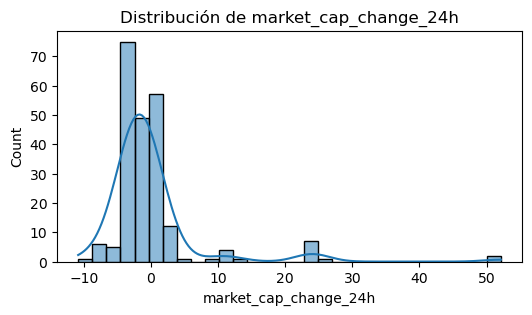


⚠️ No se detectó variable 'growth_flag' aún. Solo se mostrarán métricas de features.


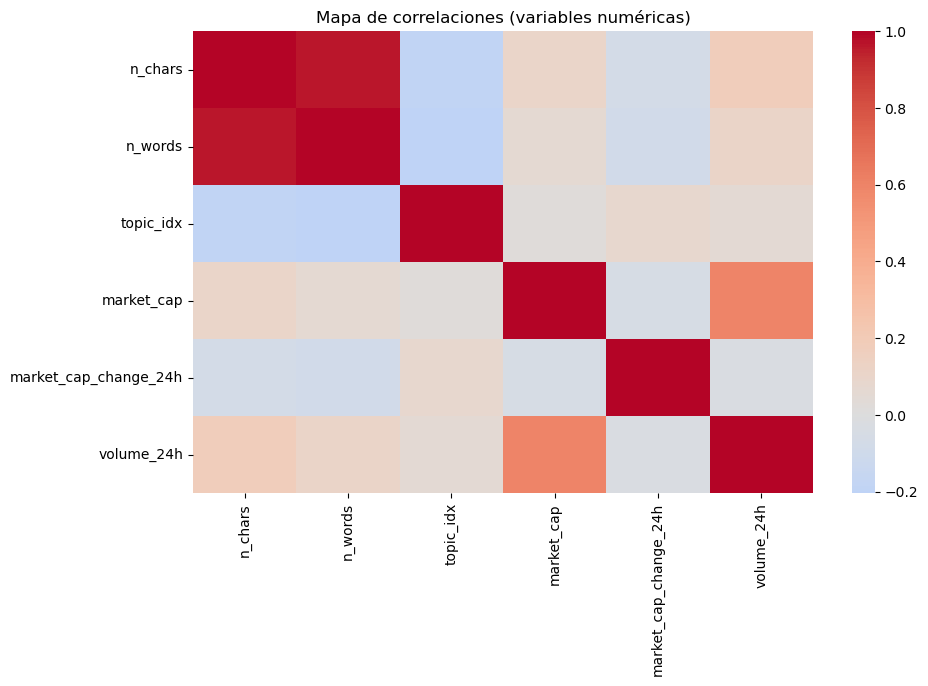


=== Cardinalidad de variables categóricas ===
fuente: 119 valores únicos
fecha: 7 valores únicos
hora: 792 valores únicos
token_mention: 35 valores únicos
primary_category_by_mention: 120 valores únicos
topic_words: 6 valores únicos


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Estructura general ===
print("🔹 Dimensiones:", df_model.shape)
print("🔹 Columnas:", list(df_model.columns))
print("\n🔹 Tipos de datos:\n", df_model.dtypes)
print("\n🔹 Valores faltantes por columna:\n", df_model.isna().sum())
print("\n🔹 Porcentaje de filas con NaN:", round(df_model.isna().mean().mean() * 100, 2), "%")

# === 2. Estadísticas numéricas ===
num_cols = df_model.select_dtypes(include=[np.number]).columns
print("\n=== Estadísticas descriptivas ===")
display(df_model[num_cols].describe(percentiles=[.1, .25, .5, .75, .9]).T)

# === 3. Distribución de variables clave ===
key_cols = ['market_cap_change_24h', 'news_count'] if 'news_count' in df_model.columns else ['market_cap_change_24h']
for col in key_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_model[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

# === 4. Balance de variable objetivo (si existe) ===
target_cols = [c for c in df_model.columns if 'growth_flag' in c]
if target_cols:
    for tcol in target_cols:
        print(f"\n--- Distribución de {tcol} ---")
        print(df_model[tcol].value_counts(dropna=False))
        sns.countplot(x=tcol, data=df_model)
        plt.title(f"Balance de clases en {tcol}")
        plt.show()
else:
    print("\n⚠️ No se detectó variable 'growth_flag' aún. Solo se mostrarán métricas de features.")

# === 5. Correlaciones rápidas (solo si hay varias numéricas) ===
if len(num_cols) > 3:
    plt.figure(figsize=(10,6))
    sns.heatmap(df_model[num_cols].corr(), annot=False, cmap="coolwarm", center=0)
    plt.title("Mapa de correlaciones (variables numéricas)")
    plt.show()

# === 6. Información de categorías ===
cat_cols = df_model.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print("\n=== Cardinalidad de variables categóricas ===")
    for c in cat_cols:
        print(f"{c}: {df_model[c].nunique()} valores únicos")


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Seccion 2: Generación de Alertas y del Modelo

# 1) Exploración y limpieza ligera de df_model
- Copia segura de df_model para evitar sobrescribirlo.

- Convierte fecha en datetime.

- Limpia textos de espacios o "None".

- Elimina duplicados.

- Muestra resumen estadístico solo de columnas numéricas.

In [ ]:
# ==========================================
# Paso 1. Exploración y limpieza inicial
# ==========================================

import pandas as pd
import numpy as np

# 1) Copia de trabajo
df = df_model.copy()

# 2) Vistazo general
print("🔹 Dimensiones:", df.shape)
print("🔹 Tipos de datos:\n", df.dtypes)

# 3) Blindaje de 'fecha' y construcción de 'fecha_dt'
df['fecha_raw'] = df['fecha'].astype(str)

looks_ddmmyyyy = df['fecha_raw'].str.match(r'^\d{2}/\d{2}/\d{4}$', na=False)

# Serie vacía (todo NaT) con mismo índice
fecha_dt = pd.Series(pd.NaT, index=df.index, dtype='datetime64[ns]')

# a) Filas con formato dd/mm/YYYY
fecha_dt.loc[looks_ddmmyyyy] = pd.to_datetime(
    df.loc[looks_ddmmyyyy, 'fecha_raw'],
    format='%d/%m/%Y',
    errors='coerce'
)

# b) Para las demás, intento general con dayfirst=True
mask_b = ~looks_ddmmyyyy
parsed_b = pd.to_datetime(df.loc[mask_b, 'fecha_raw'], dayfirst=True, errors='coerce')
fecha_dt.loc[mask_b & parsed_b.notna()] = parsed_b.loc[parsed_b.notna()]

# c) Respaldo desde publishedAt (si existe)
if 'publishedAt' in df.columns:
    pub_dt = pd.to_datetime(df['publishedAt'], errors='coerce', utc=True)
    # Si quisieras CDMX: pub_dt = pub_dt.dt.tz_convert('America/Mexico_City')
    fecha_dt.loc[fecha_dt.isna() & pub_dt.notna()] = pub_dt.dt.tz_localize(None)

# Asignación final
df['fecha_dt'] = fecha_dt.dt.normalize()
df['fecha'] = df['fecha_raw']  # conservas tu string original
print("NaN en fecha_dt:", df['fecha_dt'].isna().sum(), "| NaN en fecha:", df['fecha'].isna().sum())

# 4) Limpieza ligera de texto (sin convertir NaN a 'nan')


for col in ["fuente", "primary_category_by_mention", "token_mention"]:
    if col in df.columns:
        df[col] = df[col].astype("object")
        # convierte solo strings reales
        mask_str = df[col].notna()
        df.loc[mask_str, col] = df.loc[mask_str, col].astype(str).str.strip()
        cols = ["fuente","primary_category_by_mention","token_mention"]
        df[cols] = df[cols].apply(lambda s: s.astype(str).str.strip()
                                     .replace({"nan": np.nan, "None": np.nan, "": np.nan}))

# 5) Duplicados (si no hay 'titulo', usa clave mínima estable)
subset_dups = ["fuente", "fecha", "hora"] + ([ "titulo"] if "titulo" in df.columns else [])
before = len(df)
df = df.drop_duplicates(subset=subset_dups, keep="first")
after = len(df)
if after != before:
    print(f"🔁 Eliminados {before-after} duplicados por {subset_dups}")

# 6) Resumen de faltantes
print("\n🚫 Valores faltantes por columna:")
print(df.isna().sum())

# 7) Resumen numérico rápido (solo numéricas)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    print("\n📊 Estadísticas descriptivas:")
    display(df[num_cols].describe(percentiles=[.1, .5, .9]).T)

# 8) Confirmación final
print(f"\n✅ DataFrame limpio → {df.shape[0]} filas, {df.shape[1]} columnas")

🔹 Dimensiones: (825, 12)
🔹 Tipos de datos:
 fuente                          object
fecha                           object
hora                            object
token_mention                   object
primary_category_by_mention     object
n_chars                          int64
n_words                          int64
topic_idx                        int64
topic_words                     object
market_cap                     float64
market_cap_change_24h          float64
volume_24h                     float64
dtype: object
NaN en fecha_dt: 0 | NaN en fecha: 0
🔁 Eliminados 18 duplicados por ['fuente', 'fecha', 'hora']

🚫 Valores faltantes por columna:
fuente                           0
fecha                            0
hora                             0
token_mention                  471
primary_category_by_mention    263
n_chars                          0
n_words                          0
topic_idx                        0
topic_words                      0
market_cap                   

,count,mean,std,min,10%,50%,90%,max
n_chars,807.0,4.310892e+02,1.067222e+02,202.000000,2.630000e+02,4.380000e+02,5.520000e+02,6.410000e+02
n_words,807.0,6.823668e+01,1.848324e+01,24.000000,3.900000e+01,7.000000e+01,9.100000e+01,1.130000e+02
topic_idx,807.0,2.110285e+00,1.641273e+00,0.000000,0.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00
market_cap,214.0,1.262789e+11,4.489359e+11,0.000000,8.087218e+06,3.369710e+09,3.127917e+11,3.153699e+12
market_cap_change_24h,214.0,-8.439283e-02,7.511820e+00,-10.832133,-4.275767e+00,-1.477885e+00,2.853731e+00,5.212929e+01
volume_24h,214.0,2.398896e+10,5.770102e+10,0.000000,3.161344e+05,2.404116e+08,1.685794e+11,2.072344e+11



✅ DataFrame limpio → 807 filas, 14 columnas


In [ ]:
df_clean = df.copy()

# 2) Tópicos diarios + etiquetas amigables (opcional LLM)

Un inventario de temas por día (df_topics_daily) con:

* news_count y share_in_day (intensidad relativa).

* top_keywords y top_tokens (para auditoría/explicabilidad).

* Un nombre del tema (label_llm) corto y legible (con o sin LLM).

* Un day_topic_id único, útil para comparar días en el Paso 3 (matching de temas día a día con similitud Jaccard/TF-IDF y construir la señal de “emergente”).

In [ ]:
# ==========================================
# Paso 2. Tópicos diarios + etiquetas amigables (opcional LLM)
# ==========================================
import os
import re
import json
import numpy as np
import pandas as pd
from collections import Counter

# --------- PRE-CHECKS (sanidad del Paso 1) ---------
assert 'df_clean' in globals(), "No encuentro df_clean; corre el Paso 1 primero."
# a) fechas parseadas
assert df_clean['fecha_dt'].notna().all(), "Hay NaN en fecha_dt; revisa el Paso 1."
# b) sin duplicados obvios
assert df_clean.duplicated(['fuente','fecha','hora']).sum() == 0, "Aún hay duplicados por ['fuente','fecha','hora']."

# --------- Helpers de texto ----------
def _split_topic_words(x, top_k=8):
    """
    topic_words viene como string 'a, b, c,...'
    Devuelve las top_k más frecuentes (minúsculas, sin espacios).
    """
    if pd.isna(x):
        return []
    toks = [t.strip().lower() for t in str(x).split(',') if t.strip()]
    cnt = Counter(toks)
    return [w for (w, _) in cnt.most_common(top_k)]

def _collapse_list(series, top_k=8):
    """
    Une listas de keywords de muchas filas en un solo top_k global.
    """
    bag = Counter()
    for v in series.dropna():
        bag.update(_split_topic_words(v, top_k=top_k*4))  # juntamos de más y luego cortamos
    return [w for (w, _) in bag.most_common(top_k)]

def _mode_non_null(series):
    vals = [str(v) for v in series if pd.notna(v) and str(v).lower() not in ("none","nan","")]
    if not vals:
        return np.nan
    return Counter(vals).most_common(1)[0][0]

# --------- 2.1. Agregar por (fecha_dt, topic_idx) ----------
# métrica base: conteo y share dentro del día
daily_counts = df_clean.groupby(['fecha_dt','topic_idx'], as_index=False).agg(
    news_count=('topic_idx','size'),
    top_keywords=('topic_words', _collapse_list),
    top_tokens=('token_mention', lambda s: [t for t,c in Counter([str(x).lower() for x in s.dropna()]).most_common(5)])
)
# total noticias por día
totals = df_clean.groupby('fecha_dt', as_index=False).agg(day_total=('topic_idx','size'))
df_topics_daily = daily_counts.merge(totals, on='fecha_dt', how='left')
df_topics_daily['share_in_day'] = df_topics_daily['news_count'] / df_topics_daily['day_total']

# “categoría dominante” del día-tema (si existe)
dom_cat = (df_clean
           .groupby(['fecha_dt','topic_idx'])['primary_category_by_mention']
           .apply(_mode_non_null)
           .reset_index()
           .rename(columns={'primary_category_by_mention':'dominant_category'}))
df_topics_daily = df_topics_daily.merge(dom_cat, on=['fecha_dt','topic_idx'], how='left')

# texto candidato para nombre automático (sin LLM)
def _label_candidate(row, kmax=4):
    kws = row.get('top_keywords', []) or []
    kws = [k for k in kws if k not in ('crypto','market','price','trading','new','industry')]
    base = ", ".join(kws[:kmax])
    if pd.notna(row.get('dominant_category')):
        return f"{row['dominant_category']} — {base}" if base else str(row['dominant_category'])
    return base or f"Topic {int(row['topic_idx'])}"

df_topics_daily['label_candidate'] = df_topics_daily.apply(_label_candidate, axis=1)

# id único del tema del día (útil para tracking posterior)
df_topics_daily['day_topic_id'] = (
    df_topics_daily['fecha_dt'].dt.strftime('%Y-%m-%d') + "_t" + df_topics_daily['topic_idx'].astype(str)
)

# Orden de columnas y vista rápida
df_topics_daily = df_topics_daily[[
    'day_topic_id','fecha_dt','topic_idx','news_count','day_total','share_in_day',
    'top_keywords','top_tokens','dominant_category','label_candidate'
]].sort_values(['fecha_dt','topic_idx']).reset_index(drop=True)

print("✅ df_topics_daily listo:", df_topics_daily.shape)
display(df_topics_daily.head(12))

# --------- 2.2. (Opcional) Etiquetas amigables con LLM ---------
USE_LLM = False  # <- cámbialo a True si quieres usar OpenAI
OPENAI_API_KEY = "NO SUBIR"  # <- tu llave

def llm_name_topic(keywords, tokens=None, dom_cat=None, max_chars=30):
    """
    Pide al LLM un nombre corto (<= max_chars) con 2–4 palabras.
    Si falla, devuelve None (te quedas con label_candidate).
    """
    try:
        from openai import OpenAI
        client = OpenAI(api_key=OPENAI_API_KEY)

        kw = ", ".join(keywords or [])
        tk = ", ".join(tokens or [])
        cat = dom_cat if pd.notna(dom_cat) else ""

        prompt = (
            "Genera un nombre breve y claro (máximo 30 caracteres, 2–4 palabras) "
            "para un tema de noticias cripto.\n\n"
            f"Palabras clave: {kw}\n"
            f"Tokens mencionados: {tk}\n"
            f"Categoría dominante (si aplica): {cat}\n\n"
            "Responde SOLO con el nombre, sin comillas ni explicación."
        )

        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role":"user","content":prompt}],
            temperature=0.2,
            max_tokens=20
        )
        name = resp.choices[0].message.content.strip()
        # recorte defensivo
        return name[:max_chars]
    except Exception as e:
        # opcional: print para debug
        print(f"[LLM] error: {e}")
        return None

if USE_LLM:
    friendly = []
    for _, r in df_topics_daily.iterrows():
        name = llm_name_topic(
            keywords=r['top_keywords'],
            tokens=r['top_tokens'],
            dom_cat=r['dominant_category'],
            max_chars=30
        )
        friendly.append(name if name else r['label_candidate'])
    df_topics_daily['label_llm'] = friendly
else:
    # si no usas LLM, duplica el candidato en label_llm para tener columna homogénea
    df_topics_daily['label_llm'] = df_topics_daily['label_candidate']

# Vista compacta final del Paso 2
print("\n🧭 Resumen por día (top temas por share_in_day):")
tmp = (df_topics_daily.sort_values(['fecha_dt','share_in_day'], ascending=[True,False])
       .groupby('fecha_dt').head(3)[['fecha_dt','topic_idx','share_in_day','label_llm','top_keywords']]
      )
display(tmp)


✅ df_topics_daily listo: (40, 10)


,day_topic_id,fecha_dt,topic_idx,news_count,day_total,share_in_day,top_keywords,top_tokens,dominant_category,label_candidate
0,2025-10-10_t0,2025-10-10,0,5,39,0.128205,"[crypto, bitcoin, market, billion, digital, bt...","[xrp, bitcoin]",XRP Ledger Ecosystem,"XRP Ledger Ecosystem — bitcoin, billion, digit..."
1,2025-10-10_t1,2025-10-10,1,8,39,0.205128,"[crypto, bitcoin, bank, ai, 2025, market, new,...","[ethereum, tron]",Crypto-backed Stablecoin,"Crypto-backed Stablecoin — bitcoin, bank, ai, ..."
2,2025-10-10_t2,2025-10-10,2,13,39,0.333333,"[crypto, trump, president, china, bitcoin, mar...","[bitcoin, ethereum, dogecoin]",Bitcoin Ecosystem,"Bitcoin Ecosystem — trump, president, china, b..."
3,2025-10-10_t3,2025-10-10,3,6,39,0.153846,"[200, open, return, gt, window, false, return ...",[solana],Solana Ecosystem,"Solana Ecosystem — 200, open, return, gt"
4,2025-10-10_t4,2025-10-10,4,4,39,0.102564,"[crypto, coinbase, coindcx, exchange, market, ...","[near protocol, dogecoin, xrp]",Data Availability,"Data Availability — coinbase, coindcx, exchang..."
5,2025-10-10_t5,2025-10-10,5,3,39,0.076923,"[crypto, market, bnb, binance, morning, asia, ...","[bitcoin, aster]",Bitcoin Ecosystem,"Bitcoin Ecosystem — bnb, binance, morning, asia"
6,2025-10-11_t0,2025-10-11,0,22,107,0.205607,"[crypto, bitcoin, market, billion, digital, bt...","[bitcoin, ethereum, dogecoin, bnb, world liber...",Bitcoin Ecosystem,"Bitcoin Ecosystem — bitcoin, billion, digital,..."
7,2025-10-11_t1,2025-10-11,1,15,107,0.140187,"[crypto, bitcoin, bank, ai, 2025, market, new,...","[ethereum, bitcoin, dogecoin, hyperliquid, lit...",Crypto-backed Stablecoin,"Crypto-backed Stablecoin — bitcoin, bank, ai, ..."
8,2025-10-11_t2,2025-10-11,2,16,107,0.149533,"[crypto, trump, president, china, bitcoin, mar...","[bitcoin, cardano, near protocol]",Bitcoin Ecosystem,"Bitcoin Ecosystem — trump, president, china, b..."
9,2025-10-11_t3,2025-10-11,3,37,107,0.345794,"[200, open, return, gt, window, false, return ...","[dogecoin, solana]",Market-Making Solution,"Market-Making Solution — 200, open, return, gt"



🧭 Resumen por día (top temas por share_in_day):


,fecha_dt,topic_idx,share_in_day,label_llm,top_keywords
2,2025-10-10,2,0.333333,"Bitcoin Ecosystem — trump, president, china, b...","[crypto, trump, president, china, bitcoin, mar..."
1,2025-10-10,1,0.205128,"Crypto-backed Stablecoin — bitcoin, bank, ai, ...","[crypto, bitcoin, bank, ai, 2025, market, new,..."
3,2025-10-10,3,0.153846,"Solana Ecosystem — 200, open, return, gt","[200, open, return, gt, window, false, return ..."
9,2025-10-11,3,0.345794,"Market-Making Solution — 200, open, return, gt","[200, open, return, gt, window, false, return ..."
6,2025-10-11,0,0.205607,"Bitcoin Ecosystem — bitcoin, billion, digital,...","[crypto, bitcoin, market, billion, digital, bt..."
8,2025-10-11,2,0.149533,"Bitcoin Ecosystem — trump, president, china, b...","[crypto, trump, president, china, bitcoin, mar..."
15,2025-10-12,3,0.480000,"Data Availability — 200, open, return, gt","[200, open, return, gt, window, false, return ..."
14,2025-10-12,2,0.160000,"Bitcoin Ecosystem — trump, president, china, b...","[crypto, trump, president, china, bitcoin, mar..."
13,2025-10-12,1,0.140000,"Mantra Ecosystem — bitcoin, bank, ai, 2025","[crypto, bitcoin, bank, ai, 2025, market, new,..."
21,2025-10-13,3,0.516129,"Layer 1 (L1) — 200, open, return, gt","[200, open, return, gt, window, false, return ..."


# 3) Enlazar temas día a día y crear una señal de ‘emergente’

1. Resumimos cada día en 6 temas (los topic_idx), con su participación en el día (share_in_day = % de notas de ese tema en ese día) y una firma textual (keywords, tokens, categoría dominante, etiqueta corta).

2. Vinculamos día a día: para cada tema del día D buscamos su tema más parecido del día D-1 usando Jaccard sobre la firma (palabras en común / palabras totales). Si la similitud ≥ 0.30, decimos “es el mismo hilo” y hereda el cluster_id; si no, abre cluster nuevo.

3. Calculamos una señal de “emergente” = combinación de:

* Δshare (crecimiento vs el día anterior),

* nivel actual (share_in_day),

* recencia (penaliza días viejos con recency_w = exp(-γ * days_ago)).


df_links = una tabla “tema-por-día” con:

* prev_day_topic_id, sim_prev, prev_share_in_day → continuidad contra el día anterior.

* cluster_id → identidad del tema a través de días.

* emergence_score → qué tan “nuevo + creciente” es, penalizando lo viejo (recency_w).

top_today = los temas emergentes del último día listos para un reporte/alerta.

In [ ]:
# ==========================================
# Paso 3. Link día-a-día + señal de “emergente”
# ==========================================
import numpy as np
import pandas as pd
from collections import defaultdict

# --------- PRE-CHECKS ---------
assert 'df_clean' in globals(), "Falta df_clean (Paso 1)."
assert 'df_topics_daily' in globals(), "Falta df_topics_daily (Paso 2)."
assert df_topics_daily['fecha_dt'].notna().all(), "df_topics_daily.fecha_dt tiene NaN."

# --------- 3.1. Firma textual para medir similitud ---------
def _to_set_words(x):
    """Convierte lista o string a set de palabras (minúsculas, sin espacios extra)."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return set()
    if isinstance(x, (list, tuple)):
        toks = []
        for t in x:
            toks.extend(str(t).lower().strip().split())
        return set(toks)
    # string
    toks = []
    for t in str(x).split(','):
        toks.extend(t.lower().strip().split())
    return set(toks)

def build_signature(row):
    """
    Crea una ‘firma’ del tema combinando:
      - top_keywords
      - top_tokens
      - dominant_category (si existe)
      - label_llm o label_candidate (ya creada en paso 2)
    """
    s = set()
    s |= _to_set_words(row.get('top_keywords', []))
    s |= _to_set_words(row.get('top_tokens', []))
    s |= _to_set_words(row.get('dominant_category', None))
    # etiqueta corta
    label = row.get('label_llm', row.get('label_candidate', ''))
    s |= _to_set_words(label)
    # limpia ruido genérico
    noise = {'crypto','market','price','trading','new','industry'}
    return {w for w in s if w and w not in noise}

def jaccard(a: set, b: set) -> float:
    if not a and not b:
        return 0.0
    inter = len(a & b); union = len(a | b) or 1
    return inter / union

df_t = df_topics_daily.copy()
df_t['sig_set'] = df_t.apply(build_signature, axis=1)

# --------- 3.2. Matching D vs D-1 (solo días consecutivos) ---------
# Preparamos índice por día
by_day = {d: g.sort_values('topic_idx').reset_index(drop=True) for d, g in df_t.groupby('fecha_dt')}
all_days_sorted = sorted(by_day.keys())

links = []  # guardará match por tema (D) -> (D-1)
SIM_THRESHOLD = 0.30  # puedes ajustar*******************************************************************************************

for i in range(1, len(all_days_sorted)):
    d_prev, d_curr = all_days_sorted[i-1], all_days_sorted[i]
    prev_df, curr_df = by_day[d_prev], by_day[d_curr]

    for _, r in curr_df.iterrows():
        best_sim, best_prev_id, best_prev_share = 0.0, None, 0.0
        for _, p in prev_df.iterrows():
            sim = jaccard(r['sig_set'], p['sig_set'])
            if sim > best_sim:
                best_sim = sim
                best_prev_id = p['day_topic_id']
                best_prev_share = float(p['share_in_day'])
        links.append({
            'day_topic_id': r['day_topic_id'],
            'fecha_dt': d_curr,
            'topic_idx': int(r['topic_idx']),
            'share_in_day': float(r['share_in_day']),
            'label': r.get('label_llm', r.get('label_candidate')),
            'top_keywords': r['top_keywords'],
            'top_tokens': r['top_tokens'],
            'dominant_category': r['dominant_category'],
            'sim_prev': best_sim,
            'prev_day_topic_id': best_prev_id,
            'prev_share_in_day': best_prev_share if best_sim >= SIM_THRESHOLD else 0.0
        })

df_links = pd.DataFrame(links).sort_values(['fecha_dt','topic_idx']).reset_index(drop=True)

# --------- 3.3. Asignar cluster_id (propaga del previo si sim>=threshold) ---------
cluster_id = {}
next_cluster = 1

# Para poder encontrar la fila previa por id
row_by_id = {r['day_topic_id']: r for _, r in df_t.iterrows()}

for d in all_days_sorted:
    day_ids = df_t.loc[df_t['fecha_dt'] == d, 'day_topic_id'].tolist()
    for did in day_ids:
        # buscamos su link
        m = df_links.loc[df_links['day_topic_id'] == did]
        if m.empty:
            # no hubo match (día inicial o tema nuevo)
            if did not in cluster_id:
                cluster_id[did] = f"C{next_cluster:04d}"
                next_cluster += 1
            continue
        prev_id = m.iloc[0]['prev_day_topic_id']
        if pd.notna(prev_id) and m.iloc[0]['sim_prev'] >= SIM_THRESHOLD and prev_id in cluster_id:
            cluster_id[did] = cluster_id[prev_id]
        else:
            # nuevo cluster
            if did not in cluster_id:
                cluster_id[did] = f"C{next_cluster:04d}"
                next_cluster += 1

df_links['cluster_id'] = df_links['day_topic_id'].map(cluster_id)

# --------- 3.4. Señal “emergente” (crecimiento + recencia) ---------
# Referencia de recencia: último día disponible (tu “hoy/ayer” según cómo construiste df_clean)
last_day = df_clean['fecha_dt'].max()
df_links['days_ago'] = (last_day - df_links['fecha_dt']).dt.days.clip(lower=0)

# Δshare (si no hay previo, se toma 0)
df_links['delta_share'] = df_links['share_in_day'] - df_links['prev_share_in_day']

# Decaimiento por recencia (menos peso a días viejos)
GAMMA = 0.4  # más alto = más agresivo penalizando días viejos**********************************************************************
df_links['recency_w'] = np.exp(-GAMMA * df_links['days_ago'])

# Señal final (ajustable): 60% crecimiento + 40% nivel actual, todo con recencia
df_links['emergence_score'] = (0.6 * df_links['delta_share'] + 0.4 * df_links['share_in_day']) * df_links['recency_w']

# --------- 3.5. Salidas útiles ---------
print("✅ df_topic_links listo:", df_links.shape)
display(df_links.head(12))

# Ranking de temas del último día (o “ayer” si ese es el tope de tu colección)
top_today = (df_links[df_links['fecha_dt'] == last_day]
             .sort_values('emergence_score', ascending=False)
             .head(10)[['cluster_id','day_topic_id','label','share_in_day','delta_share','sim_prev','emergence_score','top_keywords','top_tokens','dominant_category']])
print("\n🔥 Top emergentes del día más reciente:")
display(top_today)

# (Opcional) Vista de continuidad de un cluster específico (para auditar)
cid = top_today.iloc[0]['cluster_id']
track = (df_links[df_links['cluster_id']==cid]
          .sort_values('fecha_dt')[['fecha_dt','label','share_in_day','delta_share','sim_prev','emergence_score']])
display(track)


✅ df_topic_links listo: (34, 16)


,day_topic_id,fecha_dt,topic_idx,share_in_day,label,top_keywords,top_tokens,dominant_category,sim_prev,prev_day_topic_id,prev_share_in_day,cluster_id,days_ago,delta_share,recency_w,emergence_score
0,2025-10-11_t0,2025-10-11,0,0.205607,"Bitcoin Ecosystem — bitcoin, billion, digital,...","[crypto, bitcoin, market, billion, digital, bt...","[bitcoin, ethereum, dogecoin, bnb, world liber...",Bitcoin Ecosystem,0.466667,2025-10-10_t0,0.128205,C0001,5,0.077402,0.135335,0.017416
1,2025-10-11_t1,2025-10-11,1,0.140187,"Crypto-backed Stablecoin — bitcoin, bank, ai, ...","[crypto, bitcoin, bank, ai, 2025, market, new,...","[ethereum, bitcoin, dogecoin, hyperliquid, lit...",Crypto-backed Stablecoin,0.666667,2025-10-10_t1,0.205128,C0002,5,-0.064941,0.135335,0.002316
2,2025-10-11_t2,2025-10-11,2,0.149533,"Bitcoin Ecosystem — trump, president, china, b...","[crypto, trump, president, china, bitcoin, mar...","[bitcoin, cardano, near protocol]",Bitcoin Ecosystem,0.615385,2025-10-10_t2,0.333333,C0003,5,-0.183801,0.135335,-0.006830
3,2025-10-11_t3,2025-10-11,3,0.345794,"Market-Making Solution — 200, open, return, gt","[200, open, return, gt, window, false, return ...","[dogecoin, solana]",Market-Making Solution,0.666667,2025-10-10_t3,0.153846,C0004,5,0.191948,0.135335,0.034306
4,2025-10-11_t4,2025-10-11,4,0.112150,"Bitcoin Ecosystem — coinbase, coindcx, exchang...","[crypto, coinbase, coindcx, exchange, market, ...","[bitcoin, chainlink, ethena, xrp]",Bitcoin Ecosystem,0.470588,2025-10-10_t4,0.102564,C0005,5,0.009585,0.135335,0.006849
5,2025-10-11_t5,2025-10-11,5,0.046729,"Bitcoin Ecosystem — bnb, binance, morning, asia","[crypto, market, bnb, binance, morning, asia, ...",[bitcoin],Bitcoin Ecosystem,0.900000,2025-10-10_t5,0.076923,C0006,5,-0.030194,0.135335,0.000078
6,2025-10-12_t0,2025-10-12,0,0.060000,"Sun Pump Ecosystem — bitcoin, billion, digital...","[crypto, bitcoin, market, billion, digital, bt...",[hyperliquid],Sun Pump Ecosystem,0.437500,2025-10-11_t0,0.205607,C0001,4,-0.145607,0.201897,-0.012793
7,2025-10-12_t1,2025-10-12,1,0.140000,"Mantra Ecosystem — bitcoin, bank, ai, 2025","[crypto, bitcoin, bank, ai, 2025, market, new,...","[cosmos hub, pepe]",Mantra Ecosystem,0.375000,2025-10-11_t1,0.140187,C0002,4,-0.000187,0.201897,0.011284
8,2025-10-12_t2,2025-10-12,2,0.160000,"Bitcoin Ecosystem — trump, president, china, b...","[crypto, trump, president, china, bitcoin, mar...","[bitcoin, solana, ethereum]",Bitcoin Ecosystem,0.615385,2025-10-11_t2,0.149533,C0003,4,0.010467,0.201897,0.014189
9,2025-10-12_t3,2025-10-12,3,0.480000,"Data Availability — 200, open, return, gt","[200, open, return, gt, window, false, return ...",[near protocol],Data Availability,0.466667,2025-10-11_t3,0.345794,C0004,4,0.134206,0.201897,0.055022



🔥 Top emergentes del día más reciente:


,cluster_id,day_topic_id,label,share_in_day,delta_share,sim_prev,emergence_score,top_keywords,top_tokens,dominant_category
33,C0006,2025-10-16_t5,"Proof of Stake (PoS) — bnb, binance, morning, ...",0.3,0.186243,0.526316,0.231746,"[crypto, market, bnb, binance, morning, asia, ...",[world liberty financial],Proof of Stake (PoS)
30,C0001,2025-10-16_t0,"Kava Ecosystem — bitcoin, billion, digital, btc",0.4,0.071958,0.500000,0.203175,"[crypto, bitcoin, market, billion, digital, bt...","[tether, solana, bitcoin]",Kava Ecosystem
32,C0003,2025-10-16_t2,"XRP Ledger Ecosystem — trump, president, china...",0.2,0.041270,0.642857,0.104762,"[crypto, trump, president, china, bitcoin, mar...","[xrp, bitcoin]",XRP Ledger Ecosystem
31,C0002,2025-10-16_t1,"bitcoin, bank, ai, 2025",0.1,-0.056085,0.500000,0.006349,"[crypto, bitcoin, bank, ai, 2025, market, new,...",[],NaN


,fecha_dt,label,share_in_day,delta_share,sim_prev,emergence_score
5,2025-10-11,"Bitcoin Ecosystem — bnb, binance, morning, asia",0.046729,-0.030194,0.900000,0.000078
11,2025-10-12,"Bridged Stablecoin — bnb, binance, morning, asia",0.080000,0.033271,0.636364,0.010491
17,2025-10-13,"Bitcoin Ecosystem — bnb, binance, morning, asia",0.053763,-0.026237,0.583333,0.001736
23,2025-10-14,"BNB Chain Ecosystem — bnb, binance, morning, asia",0.061538,0.007775,0.818182,0.013157
29,2025-10-15,"BNB Chain Ecosystem — bnb, binance, morning, asia",0.113757,0.052218,0.666667,0.051503
33,2025-10-16,"Proof of Stake (PoS) — bnb, binance, morning, ...",0.300000,0.186243,0.526316,0.231746


In [ ]:
df_topic_links = df_links.copy()

# 4) Generación de Alertas y Watchlist

En este paso se construyeron **alertas automáticas** y una **watchlist (lista de seguimiento)** a partir del DataFrame df_topic_links, que contiene la evolución de los tópicos día a día. El objetivo fue identificar cuáles temas están mostrando señales de crecimiento (“emergentes”) y cuáles mantienen momentum en los últimos días. Para lograrlo, se filtraron los temas del día más reciente con base en su tamaño dentro del día (share_in_day), su crecimiento respecto al día anterior (delta_share), su similitud con el día previo (sim_prev) y su puntuación combinada de emergencia (emergence_score).

Después, se generó una **watchlist** que consolida los clusters o narrativas que han estado activas en los últimos tres días, considerando aquellas que mantienen o incrementan su presencia (mean_delta ≥ 0) o que alcanzaron altos valores de emergence_score en ese periodo. Así, mientras las alertas muestran las tendencias calientes del día, la watchlist te da una vista más estratégica de los temas que pueden consolidarse o reactivarse pronto.

**Ejemplo:**

Si el 13 de octubre aparece el tópico *“Energy – open, return, 200, gt”* con `share_in_day = 0.54`, `delta_share = +0.21` y `emergence_score = 0.34`, entrará al top de alertas. Si este mismo cluster (C0004) ha aparecido consistentemente desde el 8 de octubre con un promedio de crecimiento positivo, también estará en la watchlist. En cambio, un tema como *“Bitcoin Ecosystem”* que mantiene alta presencia pero sin crecer, podría quedarse fuera de las alertas, aunque seguiría en la watchlist si se mantiene estable varios días.

In [ ]:
# ==========================================
# Paso 4 (ajustado). Alertas (Top-N) + diversidad + subetiquetas
# ==========================================
import pandas as pd
import numpy as np
import re

# ---------- 0) sanity check ----------
assert 'df_topic_links' in globals(), "df_topic_links no existe. Corre primero el Paso 3."
req_cols = {'fecha_dt','cluster_id','label','share_in_day','delta_share','sim_prev',
            'emergence_score','top_keywords','top_tokens','dominant_category'}
faltan = req_cols - set(df_topic_links.columns)
assert not faltan, f"Faltan columnas en df_topic_links: {faltan}"

df_links = df_topic_links.copy()
df_links['fecha_dt'] = pd.to_datetime(df_links['fecha_dt'], errors='coerce')
latest_day = df_links['fecha_dt'].max()
assert pd.notna(latest_day), "No puedo determinar el último día en df_topic_links."

# ---------- 1) parámetros ----------
TOP_K                = 6        # cuántas alertas mostrar
MIN_SHARE_TODAY      = 0.07     # tamaño mínimo del tema hoy
MIN_DELTA            = 0.00     # crecimiento mínimo vs ayer
MIN_SIM_PREV         = 0.30     # similitud mínima con el día anterior (para continuidad)
EMERG_QTL            = 0.75     # percentil de emergence_score para cortar (además de filtros)
USE_QTL_INSTEAD_ABS  = True     # si True, aplica percentil; si False, usa umbral fijo EMERG_MIN
EMERG_MIN            = 0.05     # si no usas percentil, umbral fijo
MAX_PER_CATEGORY     = 2        # diversificación: máximo N alertas por categoría en el TOP_K

# ---------- 2) funciones auxiliares ----------
def detect_subtopic(keywords, tokens):
    """Reglas sencillas para subetiquetar el tema (no altera df_topic_links)."""
    kws = " ".join(map(str, keywords)).lower()
    toks = " ".join(map(str, tokens)).lower()
    txt  = f"{kws} {toks}"

    # grupos de reglas (simple, extensible)
    if re.search(r'\b(sec|etf|filing|approval|outflow|inflow|spot)\b', txt):
        return "ETF / regulatorio"
    if re.search(r'\b(lightning|l2|channels|fees|rollup|ordinals?|runes|inscriptions?)\b', txt):
        # separamos ordinals de L2 si hace match
        if re.search(r'\bordinals?|runes|inscriptions?\b', txt):
            return "Ordinals / Runes"
        return "Infra / L2"
    if re.search(r'\b(mining|minería|hash|difficulty|energy|energia|halving)\b', txt):
        return "Minería / Energía"
    if re.search(r'\b(airdrop|listing|bridge|partnership|integration)\b', txt):
        return "Listings / Airdrops / Bridges"
    if re.search(r'\b(hack|exploit|breach|rug|scam)\b', txt):
        return "Seguridad / Incidente"
    if re.search(r'\b(stablecoin|usdt|usdc|tether|circle)\b', txt):
        return "Pagos / Stablecoins"
    if re.search(r'\b(defi|dex|amm|liquidity|yield|staking)\b', txt):
        return "DeFi / Liquidez"
    if re.search(r'\b(meme|doge|pepe|shib)\b', txt):
        return "Memecoins"
    if re.search(r'\b(ai|agent|llm|gpt)\b', txt):
        return "AI / Agents"
    return None  # sin subtema claro

def make_label_final(row):
    """Construye una etiqueta más específica, sin romper 'label' original."""
    sub = detect_subtopic(row.get('top_keywords', []), row.get('top_tokens', []))
    if sub:
        return f"{row['dominant_category']} — {sub}"
    # si no hay subtema, deja el label original
    return row['label']

def diversify_by_category(df_sorted, max_per_cat=2, k=6, cat_col='dominant_category'):
    """Greedy: toma en orden, respetando máximo por categoría."""
    out_rows = []
    used_per_cat = {}
    for _, r in df_sorted.iterrows():
        c = r.get(cat_col, "N/A")
        used = used_per_cat.get(c, 0)
        if used < max_per_cat:
            out_rows.append(r)
            used_per_cat[c] = used + 1
        if len(out_rows) >= k:
            break
    return pd.DataFrame(out_rows)

# ---------- 3) set de candidatos del día más reciente ----------
today = df_links[df_links['fecha_dt'] == latest_day].copy()

# umbral por percentil (opcional)
if USE_QTL_INSTEAD_ABS:
    emerg_cut = np.nanquantile(today['emergence_score'], EMERG_QTL) if len(today) else np.inf
else:
    emerg_cut = EMERG_MIN

candidates = today[
    (today['share_in_day'] >= MIN_SHARE_TODAY) &
    (today['delta_share']  >= MIN_DELTA) &
    (today['sim_prev']     >= MIN_SIM_PREV) &
    (today['emergence_score'] >= emerg_cut)
].copy()

# ---------- 4) aplica sub-etiquetas y diversificación ----------
# (a) sub-etiquetas amigables (NO cambian columnas base; añadimos 'label_final')
candidates['label_final'] = candidates.apply(make_label_final, axis=1)

# (b) orden preliminar por señal
ordered = candidates.sort_values(
    ['emergence_score','share_in_day','delta_share'],
    ascending=False
).reset_index(drop=True)

# (c) diversificación por categoría (máx N por categoría)
alerts = diversify_by_category(
    ordered,
    max_per_cat=MAX_PER_CATEGORY,
    k=TOP_K,
    cat_col='dominant_category'
).reset_index(drop=True)

# ---------- 5) vista amigable (conservando compatibilidad) ----------
# Nota: mantenemos las columnas originales; 'label_final' es adicional.
sel_cols = [
    'cluster_id','label_final','label','dominant_category',
    'share_in_day','delta_share','sim_prev','emergence_score',
    'top_keywords','top_tokens'
]
alerts_view = alerts.loc[:, [c for c in sel_cols if c in alerts.columns]]

print(f"🔥 Top emergentes del día {latest_day.date()} (n={len(alerts_view)})")
display(alerts_view)

# ---------- 6) watchlist (idéntico a tu versión original) ----------
H = 3  # ventana de días hacia atrás para formar la watchlist
cutoff = latest_day - pd.Timedelta(days=H-1)

recent = df_links[(df_links['fecha_dt'] >= cutoff) & (df_links['fecha_dt'] <= latest_day)].copy()

agg = (recent
       .groupby('cluster_id', as_index=False)
       .agg(
           last_day=('fecha_dt','max'),
           days_present=('fecha_dt','nunique'),
           mean_delta=('delta_share','mean'),
           max_emerg=('emergence_score','max'),
           last_label=('label','last'),
           last_cat=('dominant_category','last'),
           last_share=('share_in_day','last')
       ))

WATCH_MIN_DAYS   = 2
WATCH_MEAN_DELTA = 0.00
WATCH_MIN_EMERG  = np.nanquantile(recent['emergence_score'], 0.75) if len(recent) else 0.10

watchlist = agg[
    (agg['days_present'] >= WATCH_MIN_DAYS) &
    ((agg['mean_delta'] >= WATCH_MEAN_DELTA) | (agg['max_emerg'] >= WATCH_MIN_EMERG))
].copy()

watchlist = (watchlist
             .sort_values(['last_day','max_emerg','mean_delta','last_share'], ascending=[False, False, False, False])
             .reset_index(drop=True))

print(f"👀 Watchlist (últimos {H} días) — {len(watchlist)} clusters")
display(watchlist)

# ---------- 7) salida compacta (sin romper pasos 5–6) ----------
alerts_payload = alerts_view.to_dict(orient='records')
watchlist_payload = watchlist.to_dict(orient='records')

print("\nParámetros usados en Paso 4:")
print({
    "TOP_K": TOP_K,
    "MIN_SHARE_TODAY": MIN_SHARE_TODAY,
    "MIN_DELTA": MIN_DELTA,
    "MIN_SIM_PREV": MIN_SIM_PREV,
    "EMERG_QTL": EMERG_QTL if USE_QTL_INSTEAD_ABS else None,
    "EMERG_MIN": EMERG_MIN if not USE_QTL_INSTEAD_ABS else None,
    "MAX_PER_CATEGORY": MAX_PER_CATEGORY,
    "H_watchlist_days": H,
    "WATCH_MIN_DAYS": WATCH_MIN_DAYS,
    "WATCH_MEAN_DELTA": WATCH_MEAN_DELTA,
    "WATCH_MIN_EMERG": float(WATCH_MIN_EMERG) if not np.isnan(WATCH_MIN_EMERG) else None
})


🔥 Top emergentes del día 2025-10-16 (n=1)


,cluster_id,label_final,label,dominant_category,share_in_day,delta_share,sim_prev,emergence_score,top_keywords,top_tokens
0,C0006,"Proof of Stake (PoS) — bnb, binance, morning, ...","Proof of Stake (PoS) — bnb, binance, morning, ...",Proof of Stake (PoS),0.3,0.186243,0.526316,0.231746,"[crypto, market, bnb, binance, morning, asia, ...",[world liberty financial]


👀 Watchlist (últimos 3 días) — 5 clusters


,cluster_id,last_day,days_present,mean_delta,max_emerg,last_label,last_cat,last_share
0,C0006,2025-10-16,3,0.082079,0.231746,"Proof of Stake (PoS) — bnb, binance, morning, ...",Proof of Stake (PoS),0.300000
1,C0001,2025-10-16,3,0.072401,0.203175,"Kava Ecosystem — bitcoin, billion, digital, btc",Kava Ecosystem,0.400000
2,C0003,2025-10-16,3,0.041577,0.104762,"XRP Ledger Ecosystem — trump, president, china...",XRP Ledger Ecosystem,0.200000
3,C0002,2025-10-16,3,0.001075,0.067501,"bitcoin, bank, ai, 2025",Bitcoin Ecosystem,0.100000
4,C0005,2025-10-15,2,0.056281,0.098063,"Bitcoin Ecosystem — coinbase, coindcx, exchang...",Bitcoin Ecosystem,0.187831



Parámetros usados en Paso 4:
{'TOP_K': 6, 'MIN_SHARE_TODAY': 0.07, 'MIN_DELTA': 0.0, 'MIN_SIM_PREV': 0.3, 'EMERG_QTL': 0.75, 'EMERG_MIN': None, 'MAX_PER_CATEGORY': 2, 'H_watchlist_days': 3, 'WATCH_MIN_DAYS': 2, 'WATCH_MEAN_DELTA': 0.0, 'WATCH_MIN_EMERG': 0.09973743508762216}


# 5) Construir la Variable objetivo (y) y la Tabla de Features

1. Etiqueta cada (fecha_dt, cluster_id) como y=1 si cumple tus criterios de “emergente”.

2. Arma un set de features simples por (fecha, cluster).

3. Calcula ponderadores temporales para que los días recientes tengan más peso.

4. (Opcional) Estima cuántas noticias hubo para ese tema en ese día (si está disponible df_model).

In [ ]:
# ==========================================
# Paso 5. Target binario y features por (día, cluster)
# ==========================================
import numpy as np
import pandas as pd

# ---------- 0) sanity checks ----------
assert 'df_topic_links' in globals(), "df_topic_links no existe (corre Paso 3/4)."
df_t = df_topic_links.copy()
assert {'fecha_dt','cluster_id','label','share_in_day','delta_share','sim_prev',
        'emergence_score','top_keywords','top_tokens','dominant_category'}.issubset(df_t.columns), \
        "Faltan columnas esperadas en df_topic_links."

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# ==== Subetiquetas con LLM (OpenAI) + fallback ====
import os, time, json
import pandas as pd

OPENAI_API_KEY = os.getenv("NO_SUBIR")  # tu llave
USE_LLM = bool(OPENAI_API_KEY and len(OPENAI_API_KEY) > 5)

# Pequeño caché para no repetir prompts (clave: tuple(sorted(keywords), sorted(tokens), dom_cat))
_llm_cache = {}

def _llm_subtopic_label(top_keywords, top_tokens, dominant_category, max_retries=2, sleep_s=1.2):
    """
    Devuelve una sub-etiqueta corta tipo: 'ETF / regulatorio', 'DeFi / Liquidez', 'Infra / L2'...
    Si falla o no hay API key, devuelve None.
    """
    if not USE_LLM:
        return None

    try:
        kws = [str(k) for k in (top_keywords or [])][:12]
        toks = [str(t) for t in (top_tokens or [])][:12]
        key = (tuple(sorted(kws)), tuple(sorted(toks)), str(dominant_category))

        if key in _llm_cache:
            return _llm_cache[key]

        prompt = f"""
Eres un analista cripto. Con base en las señales, genera una SUB-CATEGORÍA breve (3–4 palabras)
para etiquetar un subtema dentro de la categoría mayor '{dominant_category}'.

- top_keywords: {kws}
- top_tokens: {toks}

Reglas:
- Devuelve SOLO la sub-categoría, sin explicaciones.
- Ejemplos: "ETF / regulatorio", "Infra / L2", "Pagos / Stablecoins",
  "DeFi / Liquidez", "Minería / Energía", "Seguridad / Incidente",
  "Ordinals / Runes", "RWA / Tokenización", "AI / Agents".
- Si no hay señal clara, responde "General".
""".strip()

        # --- cliente OpenAI (API v1) ---
        from openai import OpenAI
        client = OpenAI(api_key=OPENAI_API_KEY)

        for _ in range(max_retries + 1):
            try:
                resp = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[{"role":"user","content":prompt}],
                    temperature=0.2,
                    max_tokens=8
                )
                label = (resp.choices[0].message.content or "").strip()
                # limpieza defensiva:
                label = label.splitlines()[0]
                label = label.replace(":", "").replace("-", "—").strip()
                if not label:
                    label = None
                _llm_cache[key] = label
                return label
            except Exception:
                time.sleep(sleep_s)
        return None
    except Exception:
        return None

def _fallback_subtopic(top_keywords, top_tokens):
    # fallback MUY liviano por si el LLM no responde
    kws = " ".join(map(str, top_keywords or [])).lower()
    toks = " ".join(map(str, top_tokens or [])).lower()
    txt  = f"{kws} {toks}"
    if any(w in txt for w in ["etf","sec","filing","approval","outflow","inflow","spot"]):
        return "ETF / regulatorio"
    if any(w in txt for w in ["ordinals","runes","inscription"]):
        return "Ordinals / Runes"
    if any(w in txt for w in ["lightning","l2","rollup","fees","channels"]):
        return "Infra / L2"
    if any(w in txt for w in ["mining","hash","difficulty","energy","energia","halving"]):
        return "Minería / Energía"
    if any(w in txt for w in ["stablecoin","usdt","usdc","tether","circle"]):
        return "Pagos / Stablecoins"
    if any(w in txt for w in ["defi","dex","amm","liquidity","yield","staking"]):
        return "DeFi / Liquidez"
    if any(w in txt for w in ["hack","exploit","breach","rug","scam"]):
        return "Seguridad / Incidente"
    if any(w in txt for w in ["meme","doge","pepe","shib"]):
        return "Memecoins"
    if any(w in txt for w in ["ai","agent","llm","gpt"]):
        return "AI / Agents"
    return "General"

def make_label_final_llm(row):
    sub = _llm_subtopic_label(row.get('top_keywords'), row.get('top_tokens'), row.get('dominant_category'))
    if sub is None:
        sub = _fallback_subtopic(row.get('top_keywords'), row.get('top_tokens'))
    # forma final: "Categoría — Subcategoría"
    return f"{row['dominant_category']} — {sub}"

# Calcula label_final con LLM+fallback (no cambia features; puro reporting/interpretación)
df_t['label_final'] = df_t.apply(make_label_final_llm, axis=1)
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

# Si existe el df_model (noticias por fila), lo usamos para estimar volumen por día
has_news_rows = 'df_model' in globals()

# ---------- 1) parámetros de etiquetado (ajústalos a gusto) ----------
LBL = {
    # tamaño mínimo del cluster hoy (proporción dentro del día)
    'MIN_SHARE_TODAY': 0.08,
    # aumento mínimo vs ayer (puede ser 0.0 si quieres incluir momentum suave)
    'MIN_DELTA': 0.00,
    # continuidad mínima con el día previo (0-1). Baja si quieres captar “nuevas narrativas”.
    'MIN_SIM_PREV': 0.30,
    # criterio de “fuerza” de emergencia: usa cuantíl del día O umbral fijo (si EMERG_MIN no es None)
    'EMERG_QTL': 0.70,
    'EMERG_MIN': None,   # por ej. 0.06 si prefieres umbral fijo global
    # ponderación temporal: λ controla qué tan rápido se deprecian días viejos
    'LAMBDA_DECAY': 0.4,   # mayor => más peso a días recientes
}

# ---------- 2) etiquetado y=1 por día ----------
# a) umbral de emergencia por día (si no usas EMERG_MIN)
if LBL['EMERG_MIN'] is None:
    emerg_day_thr = (df_t.groupby('fecha_dt')['emergence_score']
                       .apply(lambda s: s.quantile(LBL['EMERG_QTL']))
                       .rename('emerg_thr_day'))
    df_t = df_t.merge(emerg_day_thr, on='fecha_dt', how='left')
    emerg_cond = df_t['emergence_score'] >= df_t['emerg_thr_day'].fillna(0)
else:
    df_t['emerg_thr_day'] = LBL['EMERG_MIN']
    emerg_cond = df_t['emergence_score'] >= LBL['EMERG_MIN']

y_flag = (
    (df_t['share_in_day'] >= LBL['MIN_SHARE_TODAY']) &
    (df_t['delta_share']  >= LBL['MIN_DELTA']) &
    (df_t['sim_prev']     >= LBL['MIN_SIM_PREV']) &
    (emerg_cond)
).astype(int)

df_t['y'] = y_flag

# ---------- 3) features básicos (sin texto, sin embeddings) ----------
feat_cols = [
    'share_in_day',     # tamaño del tema hoy
    'delta_share',      # cambio vs ayer
    'sim_prev',         # continuidad con ayer
    'emergence_score',  # score compuesto del Paso 3
    'recency_w',        # peso de recencia calculado en Paso 3
]
# agrega metadata útil
# agrega metadata útil
meta_cols = ['fecha_dt', 'cluster_id', 'label', 'dominant_category',
             'top_keywords', 'top_tokens', 'y', 'label_final']  # <- añade label_final

df_train = df_t[meta_cols + feat_cols].copy()

# ---------- 4) feature “volumen” estimado por día/tema (opcional si tienes df_model) ----------
# Aproxima nº de notas del tema en el día = share_in_day * total_noticias_en_el_día
if has_news_rows:
    # Asegura fecha_dt en df_model
    dfm = df_model.copy()
    if dfm['fecha'].dtype == 'O':
        # soporta "dd/mm/yyyy"
        try:
            fecha_dt_m = pd.to_datetime(dfm['fecha'], dayfirst=True, errors='coerce')
        except Exception:
            fecha_dt_m = pd.to_datetime(dfm['fecha'], errors='coerce')
    else:
        fecha_dt_m = pd.to_datetime(dfm['fecha'], errors='coerce')

    day_counts = fecha_dt_m.value_counts().to_dict()
    df_train['day_total_news'] = df_train['fecha_dt'].map(day_counts).fillna(0).astype(int)
    df_train['approx_articles'] = (df_train['share_in_day'] * df_train['day_total_news']).round().astype(int)
else:
    df_train['day_total_news'] = np.nan
    df_train['approx_articles'] = np.nan

# ---------- 5) sample_weight temporal (más peso a días recientes) ----------
# Tomamos la fecha más reciente del set como “hoy” para pesar
today_max = df_train['fecha_dt'].max()
days_ago = (today_max - df_train['fecha_dt']).dt.days.clip(lower=0).astype(int)
df_train['sample_weight'] = np.exp(-LBL['LAMBDA_DECAY'] * days_ago)

# ---------- (opcional) agregar label_final si existe ----------
if 'label_final' in df_topic_links.columns:
    df_train['label_final'] = df_topic_links.set_index(['fecha_dt','cluster_id']).loc[
        df_train.set_index(['fecha_dt','cluster_id']).index, 'label_final'
    ].values

# ---------- 6) vistas de diagnóstico ----------
print("📦 df_train listo:", df_train.shape)
print("\n🔸 Distribución y por día:")
print(df_train.groupby('fecha_dt')['y'].mean().round(3))

print("\n🔸 Balance global (y=1):", df_train['y'].mean().round(3),
      f" | positivos={df_train['y'].sum()} / n={len(df_train)}")

print("\n🔸 Rango de sample_weight:",
      float(df_train['sample_weight'].min()), "→", float(df_train['sample_weight'].max()))

print("\n🔸 Muestra (5 filas):")
display(df_train.head())

# ---------- 7) matrices para el Paso 6 (sin entrenar) ----------
X_cols = feat_cols + (['approx_articles'] if 'approx_articles' in df_train.columns else [])
X = df_train[X_cols].fillna(0.0).to_numpy()
y = df_train['y'].to_numpy().astype(int)
w = df_train['sample_weight'].to_numpy().astype(float)

print("\n✅ Listo para el Paso 6 (modelado):")
print("X shape:", X.shape, "| y shape:", y.shape, "| w shape:", w.shape)
print("Features:", X_cols)

📦 df_train listo: (34, 16)

🔸 Distribución y por día:
fecha_dt
2025-10-11    0.333
2025-10-12    0.333
2025-10-13    0.333
2025-10-14    0.333
2025-10-15    0.333
2025-10-16    0.250
Name: y, dtype: float64

🔸 Balance global (y=1): 0.324  | positivos=11 / n=34

🔸 Rango de sample_weight: 0.1353352832366127 → 1.0

🔸 Muestra (5 filas):


,fecha_dt,cluster_id,label,dominant_category,top_keywords,top_tokens,y,label_final,share_in_day,delta_share,sim_prev,emergence_score,recency_w,day_total_news,approx_articles,sample_weight
0,2025-10-11,C0001,"Bitcoin Ecosystem — bitcoin, billion, digital,...",Bitcoin Ecosystem,"[crypto, bitcoin, market, billion, digital, bt...","[bitcoin, ethereum, dogecoin, bnb, world liber...",1,Bitcoin Ecosystem — General,0.205607,0.077402,0.466667,0.017416,0.135335,109,22,0.135335
1,2025-10-11,C0002,"Crypto-backed Stablecoin — bitcoin, bank, ai, ...",Crypto-backed Stablecoin,"[crypto, bitcoin, bank, ai, 2025, market, new,...","[ethereum, bitcoin, dogecoin, hyperliquid, lit...",0,Crypto-backed Stablecoin — DeFi / Stablecoins,0.140187,-0.064941,0.666667,0.002316,0.135335,109,15,0.135335
2,2025-10-11,C0003,"Bitcoin Ecosystem — trump, president, china, b...",Bitcoin Ecosystem,"[crypto, trump, president, china, bitcoin, mar...","[bitcoin, cardano, near protocol]",0,Bitcoin Ecosystem — Política / Influencia,0.149533,-0.183801,0.615385,-0.006830,0.135335,109,16,0.135335
3,2025-10-11,C0004,"Market-Making Solution — 200, open, return, gt",Market-Making Solution,"[200, open, return, gt, window, false, return ...","[dogecoin, solana]",1,Market-Making Solution — General,0.345794,0.191948,0.666667,0.034306,0.135335,109,38,0.135335
4,2025-10-11,C0005,"Bitcoin Ecosystem — coinbase, coindcx, exchang...",Bitcoin Ecosystem,"[crypto, coinbase, coindcx, exchange, market, ...","[bitcoin, chainlink, ethena, xrp]",0,Bitcoin Ecosystem — Intercambios / Plataformas,0.112150,0.009585,0.470588,0.006849,0.135335,109,12,0.135335



✅ Listo para el Paso 6 (modelado):
X shape: (34, 6) | y shape: (34,) | w shape: (34,)
Features: ['share_in_day', 'delta_share', 'sim_prev', 'emergence_score', 'recency_w', 'approx_articles']


In [ ]:
print(len(df_model), "→", len(df_train))
print(df_model.columns)
print(df_train.columns)

825 → 34
Index(['fuente', 'fecha', 'hora', 'token_mention',
       'primary_category_by_mention', 'n_chars', 'n_words', 'topic_idx',
       'topic_words', 'market_cap', 'market_cap_change_24h', 'volume_24h'],
      dtype='object')
Index(['fecha_dt', 'cluster_id', 'label', 'dominant_category', 'top_keywords',
       'top_tokens', 'y', 'label_final', 'share_in_day', 'delta_share',
       'sim_prev', 'emergence_score', 'recency_w', 'day_total_news',
       'approx_articles', 'sample_weight'],
      dtype='object')


# 6) Modelado con Regresión Logística

Incluye validación “leave-one-day-out” (evalúa generalización a días nuevos), manejo de folds con una sola clase, métricas promedio y un entrenamiento final para coeficientes (importancia) y predicciones del día más reciente.

In [ ]:
# ==========================================
# Paso 6 (versión sin fuga): y_{t+1}
# Construye la etiqueta "será tendencia mañana" y evalúa con LODO
# ==========================================
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss

assert 'df_topic_links' in globals(), "df_topic_links no existe. Corre los pasos previos."

# ---------- 0) Copia base y armoniza tipos ----------
dfL = df_topic_links.copy()
dfL['fecha_dt'] = pd.to_datetime(dfL['fecha_dt'], errors='coerce')
dfL = dfL.sort_values(['fecha_dt', 'topic_idx'], ignore_index=True)

# ---------- 0.1) Reusar columnas de pasos previos (si existen) ----------
# Evita recalcular cosas aquí para que coincidan con Paso 3/4/5
if 'df_train' in globals():
    cols_merge = []
    for c in ['approx_articles', 'recency_w', 'label_final']:
        if c in df_train.columns:
            cols_merge.append(c)
    if cols_merge:
        dfL = dfL.merge(
            df_train[['fecha_dt', 'cluster_id'] + cols_merge].drop_duplicates(),
            on=['fecha_dt', 'cluster_id'], how='left'
        )

# ---------- 0.2) Fallbacks robustos (solo si faltan) ----------
# approx_articles
if 'approx_articles' not in dfL.columns:
    # aprox volumen del tópico si no tienes df_train con ese campo
    day_counts = dfL.groupby('fecha_dt')['share_in_day'].transform(lambda s: np.round(100 * s.sum()))
    dfL['approx_articles'] = (dfL['share_in_day'] * day_counts).clip(lower=1).astype(int)
else:
    if dfL['approx_articles'].isna().any():
        day_counts = dfL.groupby('fecha_dt')['share_in_day'].transform(lambda s: np.round(100 * s.sum()))
        dfL['approx_articles'] = dfL['approx_articles'].fillna(
            (dfL['share_in_day'] * day_counts).clip(lower=1)
        ).astype(int)

# recency_w
max_day = dfL['fecha_dt'].max()
if 'recency_w' not in dfL.columns:
    dfL['recency_w'] = np.exp(-0.5 * (max_day - dfL['fecha_dt']).dt.days)
else:
    dfL['recency_w'] = dfL['recency_w'].fillna(
        np.exp(-0.5 * (max_day - dfL['fecha_dt']).dt.days)
    )

# Fallbacks solo si faltan
if 'approx_articles' not in dfL.columns or dfL['approx_articles'].isna().all():
    # aprox volumen del tópico (muy simple si no hay df_train)
    day_counts = dfL.groupby('fecha_dt')['share_in_day'].transform(lambda x: np.round(100 * x.sum()))
    dfL['approx_articles'] = (dfL['share_in_day'] * day_counts).clip(lower=1).astype(int)

if 'recency_w' not in dfL.columns or dfL['recency_w'].isna().any():
    # peso de recencia decreciente (solo si faltaba)
    max_day = dfL['fecha_dt'].max()
    dfL['recency_w'] = dfL['recency_w'].fillna(np.exp(-0.5 * (max_day - dfL['fecha_dt']).dt.days))

# ---------- 1) Parámetros de “qué es tendencia” (para t+1) ----------
# (Puedes alinearlos con Paso 4 si ya los definiste allí)
TOP_K           = 6
MIN_SHARE_TODAY = 0.08
MIN_DELTA       = 0.00
MIN_SIM_PREV    = 0.30
EMERG_QTL       = 0.60   # percentil del día
EMERG_MIN       = None   # si no es None, se usa este umbral absoluto

# ---------- 2) Conjunto de “tendencias” por día (lo que mañana cuenta como 1) ----------
emergent_by_day = {}
for day, g in dfL.groupby('fecha_dt'):
    if EMERG_MIN is None:
        thr = g['emergence_score'].quantile(EMERG_QTL) if len(g) else np.inf
    else:
        thr = EMERG_MIN

    cand = g[
        (g['share_in_day'] >= MIN_SHARE_TODAY) &
        (g['delta_share']  >= MIN_DELTA) &
        (g['sim_prev']     >= MIN_SIM_PREV) &
        (g['emergence_score'] >= thr)
    ].copy()

    cand = cand.sort_values('emergence_score', ascending=False).head(TOP_K)
    emergent_by_day[day] = set(cand['cluster_id'].tolist())

# ---------- 3) Etiqueta y_{t+1} para cada fila (día t, cluster c) ----------
uniq_days = sorted(dfL['fecha_dt'].dropna().unique())
next_day_map = {d: uniq_days[i+1] for i, d in enumerate(uniq_days[:-1])}

y_next = []
for _, r in dfL.iterrows():
    d = r['fecha_dt']; c = r['cluster_id']
    if pd.isna(d) or d not in next_day_map:
        y_next.append(np.nan)
    else:
        d1 = next_day_map[d]
        y_next.append(1 if c in emergent_by_day.get(d1, set()) else 0)

dfL['y_next'] = y_next
df_train_shift = dfL.dropna(subset=['y_next']).copy()
df_train_shift['y_next'] = df_train_shift['y_next'].astype(int)

dfL['y_next'] = y_next

# usa dfL ya con recency_w/approx_articles
df_train_shift = dfL.dropna(subset=['y_next']).copy()
df_train_shift['y_next'] = df_train_shift['y_next'].astype(int)


# (opcional) asegúrate de que no haya infs ni nans residuales
for c in ['approx_articles', 'recency_w']:
    if c in dfL.columns:
        dfL[c] = pd.to_numeric(dfL[c], errors='coerce').fillna(0)

# ---------- 3.5) Verificación dura de columnas requeridas ----------
req_cols = {'share_in_day','delta_share','sim_prev','emergence_score','recency_w','approx_articles'}
missing = req_cols - set(df_train_shift.columns)
assert not missing, f"Faltan columnas requeridas para features: {missing}"

# ---------- 4) Features SOLO del día t (idénticos a Paso 5 + approx_articles) ----------
X_cols = ['share_in_day', 'delta_share', 'sim_prev', 'emergence_score', 'recency_w', 'approx_articles']
X = df_train_shift[X_cols].fillna(0.0).copy()
y = df_train_shift['y_next'].copy()
w = df_train_shift['recency_w'].copy()  # peso temporal (recency_w)

print(f"📦 df_train_shift listo: {df_train_shift.shape}")
print("\n🔸 Balance global (y_next=1):", y.mean().round(3),
      f" | positivos={int(y.sum())} / n={len(y)}")

# ---------- 5) Evaluación Leave-One-Day-Out (LODO) ----------
days = sorted(df_train_shift['fecha_dt'].unique())
results = []

for i, test_day in enumerate(days, start=1):
    tr = df_train_shift['fecha_dt'] != test_day
    te = df_train_shift['fecha_dt'] == test_day

    # Asegura que haya ambas clases en train y test
    if y[te].nunique() < 2 or y[tr].nunique() < 2:
        results.append({
            'fold': i, 'test_day': test_day.date(), 'n_test': int(te.sum()),
            'auc_roc': np.nan, 'avg_prec': np.nan, 'acc': np.nan, 'logloss': np.nan,
            'note': 'clase única en train/test'
        })
        continue

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=500, random_state=42))
    ])
    pipe.fit(X.loc[tr], y.loc[tr], clf__sample_weight=w.loc[tr])

    p = pipe.predict_proba(X.loc[te])[:, 1]
    results.append({
        'fold': i,
        'test_day': test_day.date(),
        'n_test': int(te.sum()),
        'auc_roc': float(roc_auc_score(y.loc[te], p)),
        'avg_prec': float(average_precision_score(y.loc[te], p)),
        'acc': float(accuracy_score(y.loc[te], (p >= 0.5).astype(int))),
        'logloss': float(log_loss(y.loc[te], p, labels=[0,1])),
        'note': ''
    })

df_eval_shift = pd.DataFrame(results)
print("\n📊 Métricas por día (Leave-One-Day-Out con y_{t+1}):")
display(df_eval_shift)

valid = df_eval_shift['auc_roc'].notna()
if valid.any():
    print("\n📌 Promedios (solo folds válidos):")
    display(df_eval_shift.loc[valid, ['auc_roc','avg_prec','acc','logloss']].mean().to_frame('mean').T)
else:
    print("\n⚠️ No hubo folds válidos. Ajusta umbrales o período.")

# ---------- 6) Importancia de variables ----------
pipe_full = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, random_state=42))
])
pipe_full.fit(X, y, clf__sample_weight=w)
clf = pipe_full.named_steps['clf']

coefs = pd.DataFrame({
    'feature': X_cols,
    'coef': clf.coef_[0]
}).sort_values('coef', ascending=False)
coefs['odds_ratio'] = np.exp(coefs['coef']).round(3)

print("\n🧭 Importancia de variables (coeficientes en escala estandarizada):")
display(coefs)

# ---------- 7) Scoring del día más reciente (predicción de “mañana”) ----------
last_day = dfL['fecha_dt'].max()
today_rows = dfL[dfL['fecha_dt'] == last_day].copy()
if not today_rows.empty:
    X_today = today_rows[X_cols].fillna(0.0)
    today_rows['p_tendencia_tplus1'] = pipe_full.predict_proba(X_today)[:, 1]

    # Mostrar label_final si existe, si no, usa label
    show_label = 'label_final' if 'label_final' in today_rows.columns else 'label'

    print(f"\n🔥 Probabilidad de tendencia MAÑANA — día más reciente ({last_day.date()}):")
    cols_view = ['fecha_dt','cluster_id', show_label, 'dominant_category',
                 'share_in_day','delta_share','sim_prev','emergence_score',
                 'recency_w','approx_articles','p_tendencia_tplus1']
    display(today_rows[cols_view].sort_values('p_tendencia_tplus1', ascending=False))
else:
    print("\n(no hay filas para el día más reciente)")


📦 df_train_shift listo: (30, 21)

🔸 Balance global (y_next=1): 0.367  | positivos=11 / n=30

📊 Métricas por día (Leave-One-Day-Out con y_{t+1}):


,fold,test_day,n_test,auc_roc,avg_prec,acc,logloss,note
0,1,2025-10-11,6,0.500000,0.450000,0.666667,0.652585,
1,2,2025-10-12,6,0.125000,0.291667,0.666667,0.765275,
2,3,2025-10-13,6,0.875000,0.833333,0.666667,0.567734,
3,4,2025-10-14,6,0.555556,0.588889,0.500000,0.764723,
4,5,2025-10-15,6,0.750000,0.583333,0.666667,0.608336,



📌 Promedios (solo folds válidos):


,auc_roc,avg_prec,acc,logloss
mean,0.561111,0.549444,0.633333,0.671731



🧭 Importancia de variables (coeficientes en escala estandarizada):


,feature,coef,odds_ratio
2,sim_prev,0.481771,1.619
3,emergence_score,0.175940,1.192
1,delta_share,0.168388,1.183
0,share_in_day,0.119950,1.127
5,approx_articles,-0.037132,0.964
4,recency_w,-0.105176,0.900



🔥 Probabilidad de tendencia MAÑANA — día más reciente (2025-10-16):


,fecha_dt,cluster_id,label_final,dominant_category,share_in_day,delta_share,sim_prev,emergence_score,recency_w,approx_articles,p_tendencia_tplus1
33,2025-10-16,C0006,Proof of Stake (PoS) — General,Proof of Stake (PoS),0.3,0.186243,0.526316,0.231746,1.0,3,0.528352
30,2025-10-16,C0001,Kava Ecosystem — DeFi / Interoperabilidad,Kava Ecosystem,0.4,0.071958,0.500000,0.203175,1.0,4,0.451702
32,2025-10-16,C0003,XRP Ledger Ecosystem — General,XRP Ledger Ecosystem,0.2,0.041270,0.642857,0.104762,1.0,2,0.408969
31,2025-10-16,C0002,nan — General,NaN,0.1,-0.056085,0.500000,0.006349,1.0,1,0.174829


# Resumen de la entrega 4.

## Durante esta entrega se presenta un avance significativo respecto a la iteración de la semana anterior, representando un salto cualitativo en el desarrollo del proceso. La evolución del flujo de trabajo se estructura en dos componentes principales:

### A. Competencia de métodos para la generación de etiquetas: Se implementa un esquema comparativo entre dos enfoques para la generación automática de etiquetas temáticas.
#### 1. El primer enfoque combina LDA con TF-IDF (Term Frequency–Inverse Document Frequency), con el objetivo de identificar tópicos relevantes a partir de la distribución estadística de términos.
#### 2. El segundo enfoque utiliza un modelo de lenguaje de gran escala (gpt-4o-mini) para generar etiquetas de manera contextual y semánticamente enriquecida.
#### Ambos métodos se evalúan en términos de coherencia temática y precisión en la asignación de etiquetas.

### B. Ampliación del proceso de análisis temporal y generación de alertas: Una vez definido el método óptimo de generación de etiquetas, se integra un módulo de análisis que compara la evolución de los tópicos a lo largo de distintos periodos de tiempo.

#### Este módulo permite:
#### 1.Evaluar la frecuencia y variabilidad de los temas identificados.
#### 2. Detectar anomalías o cambios significativos en la aparición de determinados tópicos.
#### 3. Generar alertas automáticas basadas en dichos cambios (sin ejecución de envío en esta fase).

## Con estas mejoras, se consolida la primera versión funcional integral del proceso previsto, incorporando tanto la lógica analítica como la implementación dentro de la plataforma IBM, además de la automatización de la actualización del flujo de trabajo.

## Quedan pendientes dos componentes para completar el ciclo operativo:
### 1. El envío automatizado de notificaciones correspondientes a las alertas generadas.
### 2. El almacenamiento histórico de las alertas emitidas para su posterior trazabilidad y análisis.

# Comparación de generación de etiquetas usando openAI vs LDA & TF‑IDF:

## En la sección "Seccion 2: Generación de Alertas y del Modelo", segmento "2) Tópicos diarios + etiquetas amigables (opcional LLM)", utlizamos gpt-4o-mini y LDA para generar las etiquetas de cada noticia.

## Observaciones:

### A. Caracteristicas de opciones:
#### LDA: Método no supervisado y estadístico, basado en la co-ocurrencia de palabras dentro de documentos.Asume que cada documento está compuesto por una mezcla de tópicos latentes, y cada tópico está representado por una distribución de palabras
#### gpt-4o-mini: Basado en redes neuronales profundas (transformers) entrenadas con enormes cantidades de texto. Posee comprensión semántica y contextual, por lo que capta significados, relaciones y matices más allá de la frecuencia de palabras. Puede inferir etiquetas descriptivas o creativas, incluso cuando los términos relevantes no aparecen explícitamente en el texto.

### B. Ventajas teóricas.
#### LDA: 1) Interpretabilidad estadística: es posible visualizar los tópicos, las palabras más representativas y sus pesos. 2) Reproducible y estable: siempre que se mantenga el mismo dataset y parámetros. 3) Ligero y económico: no requiere gran poder computacional. 4) Transparente: los resultados se explican mediante relaciones de frecuencia y probabilidad.
#### gpt-4o-mini: 1) Alta coherencia semántica: las etiquetas suelen ser más naturales, significativas y cercanas a cómo las generaría un analista humano. 2) Capacidad contextual: entiende ironía, relaciones causa-efecto o temas implícitos. 3) Flexibilidad: puede adaptarse a distintos dominios (noticias políticas, economía, deportes, etc.) sin reentrenar el modelo. 4) Multilingüe: maneja textos en varios idiomas sin requerir ajustes.

### C. Desventajas teóricas.
#### LDA: 1) Poca comprensión semántica: se basa en frecuencias, no en significado. Palabras sinónimas o contextualmente similares pueden dividirse en tópicos distintos. 2) Etiquetas poco naturales: los temas suelen representarse por listas de palabras clave, no por etiquetas legibles o descriptivas. 3) Sensibilidad a parámetros: el número de tópicos y el preprocesamiento influyen fuertemente en la calidad de los resultados. 4) Dificultad con textos cortos (como titulares): hay poca información estadística disponible.
#### gpt-4o-mini: 1) Menor reproducibilidad: las etiquetas pueden variar ligeramente entre ejecuciones (aleatoriedad generativa). 2) Dependencia del prompt: los resultados dependen de cómo se formule la instrucción. 3) Coste computacional: requiere más recursos y/o acceso a la API del modelo. 4) Menor transparencia: difícil explicar por qué eligió una etiqueta específica (modelo tipo “caja negra”).

### D. Restultados del proceso. En la tabla "df_topics_daily" podemos observar la salida de LDA y gpt, debido al filtro de palabras que usamos, los resultamos que encontramos entre ambos modelos es muy parecido, es una etapa temprana para hacer una desición final, por el momento usaremos LDA por ser un proceso más simple. A medida que busquemos generar un resultado más complejo o con mayor grado de desarrollo, volveremos a evaluar la opción de gpt para evaluar cual es la mejor opción más interprable y completa.